# Global Imports

In order to run the code in this notebook, you need to have TensorFlow and Keras (with TensorFlow backend) installed.

Below are the necessary imports, as well as some helper functions used throughout. Execute these each time you open the notebook.

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

%matplotlib inline
import math
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import sys
from PIL import Image

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17832107760992614747, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3173357977
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9235852390864640475
 physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [2]:
# Needed for resetting a tensorflow graph
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


def random_batch(X_train, y_train, batch_size):
    index_set = np.random.randint(0, X_train.shape[0], batch_size)
    X_batch = X_train[index_set]
    y_batch = y_train[index_set]
    return X_batch, y_batch

def random_batch_1d(X_train, batch_size):
    m = X_train.shape[0]
    index_set = np.random.randint(0, m, batch_size)
    return X_train[index_set]


def plot_image(image, pad=2):
    image = image - image.min()
    
    if len(image.shape) == 3:
        channels = image.shape[2]
    else:
        channels = 1
        
    if channels == 1:
        plt.imshow(image.reshape([height,width]), cmap="gray", interpolation="nearest")
    else:
        plt.imshow(image)
    plt.axis("off")
    
    
def combine_images(images, rows=None, cols=None):
    n_images = images.shape[0]
    shape = images.shape[1:]
    
    if rows == None or cols == None:
        cols = int(math.sqrt(n_images))
        rows = int(math.floor(float(n_images)/cols))
    
    if len(shape) == 3:
        channels = shape[2]
    else:
        channels = 1
    
    if channels == 1:
        image = np.zeros((rows*shape[0], cols*shape[1]), dtype=images.dtype)
    else:
        image = np.zeros((rows*shape[0], cols*shape[1], shape[2]), dtype=images.dtype)
    #print(generated_images.shape, shape, image.shape)
    
    for row in range(rows):
        for col in range(cols):
            img_index = row * cols + col
            img = images[img_index]
            if channels == 1:
                image[
                    row*shape[0]:(row+1)*shape[0], 
                    col*shape[1]:(col+1)*shape[1]
                ] = img.reshape((shape[0], shape[1]))
            else:
                image[
                    row*shape[0]:(row+1)*shape[0], 
                    col*shape[1]:(col+1)*shape[1],
                    :
                ] = img.reshape((shape[0], shape[1], shape[2]))
    return image

Below we test how much of a training set can be covered with random batches, and how much overlap there is.

min_hits: 0 | max_hits: 26 | mean: 9.98238 | omitted: 3


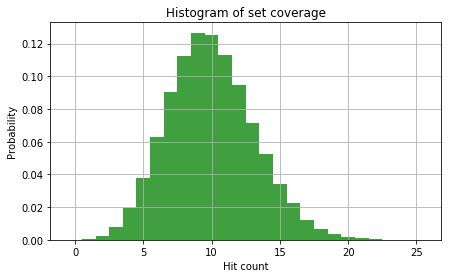

In [60]:
m = 100000 #size of training set

epochs = 10
batch_size = 150
n_batches = m // batch_size

T_set = np.zeros(m)

for epoch in range(epochs):
    for iteration in range(n_batches):
        random_indeces = np.random.randint(0, m, batch_size)
        T_set[random_indeces] += 1
        
avg_hits = np.mean(T_set)
min_hits = int(min(T_set))
max_hits = int(max(T_set))
omitted = sum(T_set == 0)
print('min_hits:', min_hits, '| max_hits:', max_hits, '| mean:', avg_hits, '| omitted:', omitted)

plt.figure(figsize=(7,4))
plt.hist(T_set, bins=max_hits, density=True, histtype='bar', align='left', facecolor='g', alpha=0.75)
plt.xlabel('Hit count')
plt.ylabel('Probability')
plt.title('Histogram of set coverage')
plt.grid(True)

plt.show()

# Stacked Autoencoders

An autoencoder is a type of neural network that can learn efficient representations of the data (called *codings*). It is comprised of stacking two neural networks together: an *encoder* followed by a *decoder*.

For example, the MNIST dataset contains images of size $28\times28\times1$, a total of $784$ features which could be decreased to a vector of size at least 10 (since there are 10 labels), but to add variation in the reconstruction.

## Data Import (MNIST)

In [193]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape)

height = X_train.shape[1]
width = X_train.shape[2]
channels = 1

X_train = X_train.astype(np.float32) / 255.0 #ensure pixel values are between 0 and 1
X_train = X_train.reshape((X_train.shape[0], height, width, channels))
X_test = X_test.astype(np.float32) / 255.0 #ensure pixel values are between 0 and 1
X_test = X_test.reshape((X_test.shape[0], height, width, channels))

# Run this if you don't use the whole training set
if False:
    m = 10000
    random_indeces = np.random.randint(0, X_train.shape[0], np.min(m, X_train.shape[0]))
    X_train = X_train[random_indeces]

print(X_train.shape, X_test.shape)

(60000, 28, 28) (60000,)
(60000, 28, 28, 1) (10000, 28, 28, 1)


## Dense Model `k_auto0`

A dense autoencoder for MNIST consists of a dense neural network with a layout similar to this:
<img src="./images/autoencoder_dense.png" style="width:50%">

The hidden layers 1 and 3 are not necessary. For instance, one can also use a simpler architecture such as inputs -> codings -> outputs. In this case, we can think of the codings as a projection of the input space onto a smaller dimensional subspace. 

In fact, if we don't use any nonlinear activations, training will result in the model trying to create codings (projections) that maximize the distance between the projected training instances, essentially performing PCA.

In [363]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.core import Activation, Dense, Flatten, Reshape
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization

n_codings = 16
model_name = 'k_auto0'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

In [243]:
K.clear_session()
n_inputs = height * width * channels


# Build the encoder part of the model
#
encoder = Sequential(name="encoder")

encoder.add(Flatten(input_shape=(height, width, channels, ), name="input"))
encoder.add(Dense(units=250))
encoder.add(Activation('relu'))
#encoder.add(LeakyReLU(alpha=0.05, name='activ1_1'))

# Codings layer - I choose the codings to be between -1 and 1, but you don't have to
encoder.add(Dense(units=n_codings))
encoder.add(Activation('tanh', name='codings'))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               196250    
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4016      
_________________________________________________________________
codings (Activation)         (None, 16)                0         
Total params: 200,266
Trainable params: 200,266
Non-trainable params: 0
_________________________________________________________________


In [244]:
# Build the decoder part of the model
#
n_outputs = n_inputs

decoder = Sequential(name="decoder")

decoder.add(Dense(units=320, input_shape=(n_codings,), name='codings_in'))
decoder.add(Activation('relu'))
#decoder.add(LeakyReLU(alpha=0.05))

decoder.add(Dense(units=n_outputs))
decoder.add(Activation('sigmoid'))

decoder.add(Reshape(target_shape=(height,width,channels), name='output'))

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
codings_in (Dense)           (None, 320)               5440      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               251664    
_________________________________________________________________
activation_2 (Activation)    (None, 784)               0         
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 257,104
Trainable params: 257,104
Non-trainable params: 0
_________________________________________________________________


In [245]:
# Stack the two together
#
# NOTE: this could have all been done in a single sequential model, but I chose
# this approach to be able to feed random values into the decoder and see what happens
#
model = Sequential()
model.add(encoder)
model.add(decoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 16)                200266    
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         257104    
Total params: 457,370
Trainable params: 457,370
Non-trainable params: 0
_________________________________________________________________


### Optimizer

In [246]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta(lr=0.15)


encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.compile(loss='mean_squared_error', optimizer=optimizer)

### Train / Save / Restore

In [250]:
epochs = 50
batch_size = 200

history = model.fit(
    X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

score = model.evaluate(X_test, X_test, verbose=1)
print("Test score:", score)

Epoch 1/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.0187
Epoch 2/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0177
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0170
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0163
Epoch 5/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0158
Epoch 6/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.0153
Epoch 7/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0148
Epoch 8/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0144
Epoch 9/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0140
Epoch 10/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0136
Epoch 11/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0134
Epoch 12/50
60000/60000 [===========================

In [251]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

In [478]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')
model= load_model(model_file + '.h5')

### Reconstruction Output

Let's take a look at how well the reconstructions look:

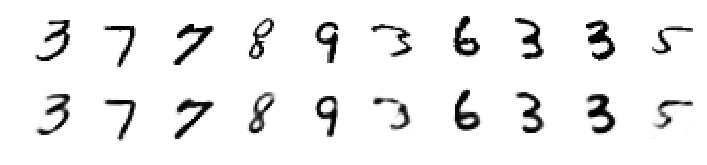

In [366]:
n_digits = 10

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

The reconstructions look slightly blurry, but overall very good! We might be able to get away with encodings of smaller dimension.

### Random Encodings

One thing to try is to feed a randomly generated encoding vector into the decoder. Let's see what we get if we use the model `k_auto0`:

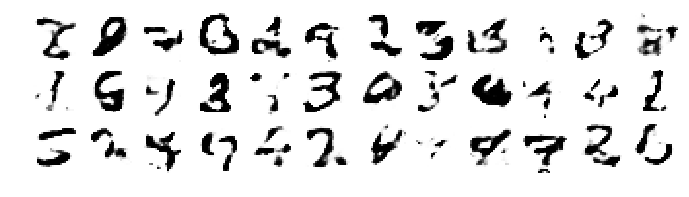

In [367]:
rows = 3
cols = 12
n_digits = rows * cols

#codings_in = noise = np.random.uniform(0, 1, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

### Encoding Distributions

Decoding a randomly generated encoding vector does NOT result in very clear images that look like those in the MNIST dataset. They have some resemblance, but it's vague.

Let's have a look at what actual encodings look like, to see how we can remedy the problem. First we use the encoder model `k_auto0` to encode the entire training set.

In [368]:
X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

60000/60000 [==============================] - 2s 36us/step
(60000, 16)


Let's plot a few of the encoded vectors' coodinates:

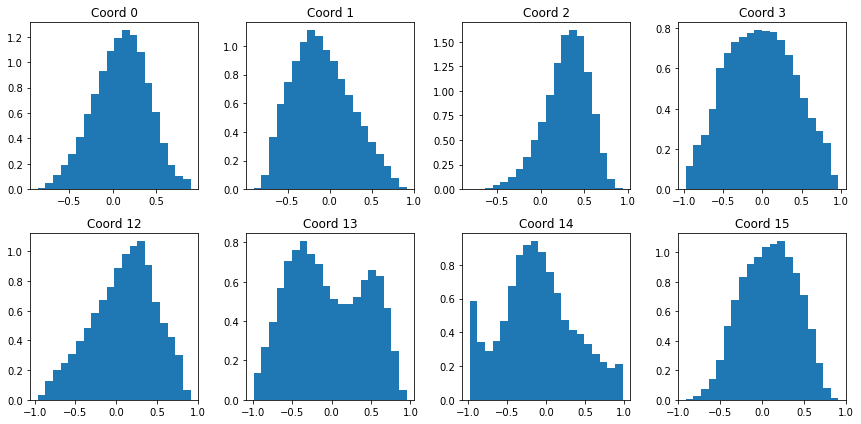

In [369]:
showAll = False

coord_indeces = np.array([
    [ 0, 1, 2, 3],
    [ 12, 13, 14, 15]
])

if showAll:
    n_cols = 4
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

The distributions of the coordinates are all different. No wonder feeding in a random encoding vector with coordinates sampled from a gaussian distribution didn't generate anything legible!

*Variational autoencoders* solve this problem.

### PCA

In [480]:
from sklearn.decomposition import PCA

n_points = 5000

X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch, verbose=True)
print(X_enc.shape)

pca = PCA(n_components=2)
X2d = pca.fit_transform(X_enc)
print(X2d.shape)

5000/5000 [==============================] - 0s 87us/step
(5000, 16)
(5000, 2)


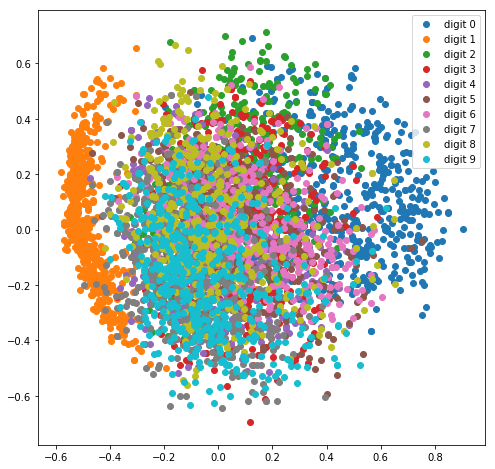

In [481]:
index_list = []
for i in range(10):
    index_list.append(y_batch == i)

plt.figure(figsize=(8,8))
for i in range(10):
    plt.scatter(
        X2d[:, 0][index_list[i]], 
        X2d[:, 1][index_list[i]], 
        cmap=y_batch[index_list[i]], 
        marker='o', label=str('digit ' + str(i))
    )

plt.legend()
plt.show()

## Dense Model `k_auto1`

Same as `k_auto0` but with `relu` activation at output.

In [375]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.core import Activation, Dense, Flatten, Reshape
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization

n_codings = 30
model_name = 'k_auto1'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

In [313]:
K.clear_session()
n_inputs = height * width * channels


# Build the encoder part of the model
#
encoder = Sequential(name="encoder")

encoder.add(Flatten(input_shape=(height, width, channels, ), name="input"))
encoder.add(Dense(units=250))
encoder.add(Activation('relu'))
#encoder.add(LeakyReLU(alpha=0.05))

encoder.add(Dense(units=n_codings)) # Codings layer
encoder.add(Activation('relu', name='codings'))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               196250    
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                7530      
_________________________________________________________________
codings (Activation)         (None, 30)                0         
Total params: 203,780
Trainable params: 203,780
Non-trainable params: 0
_________________________________________________________________


In [314]:
# Build the decoder part of the model
#
n_outputs = n_inputs

decoder = Sequential(name="decoder")

decoder.add(Dense(units=320, input_shape=(n_codings,), name='codings_in'))
decoder.add(Activation('relu'))

decoder.add(Dense(units=n_outputs))
decoder.add(Activation('sigmoid'))

decoder.add(Reshape(target_shape=(height,width,channels), name='output'))

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
codings_in (Dense)           (None, 320)               9920      
_________________________________________________________________
activation_2 (Activation)    (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               251664    
_________________________________________________________________
activation_3 (Activation)    (None, 784)               0         
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 261,584
Trainable params: 261,584
Non-trainable params: 0
_________________________________________________________________


In [315]:
# Stack the two together
#
# NOTE: this could have all been done in a single sequential model, but I chose
# this approach to be able to feed random values into the decoder and see what happens
#
model = Sequential()
model.add(encoder)
model.add(decoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 30)                203780    
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         261584    
Total params: 465,364
Trainable params: 465,364
Non-trainable params: 0
_________________________________________________________________


### Optimizer

In [316]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta(lr=0.15)


encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.compile(loss='mean_squared_error', optimizer=optimizer)

### Train / Save / Restore

In [317]:
epochs = 20
batch_size = 200

history = model.fit(
    X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

score = model.evaluate(X_test, X_test, verbose=1)
print("Test score:", score)

Epoch 1/20
60000/60000 [==============================] - 2s 41us/step - loss: 0.0466
Epoch 2/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.0184
Epoch 3/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.0138
Epoch 4/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.0121
Epoch 5/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.0110
Epoch 6/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.0102
Epoch 7/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.0097
Epoch 8/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.0092
Epoch 9/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.0089
Epoch 10/20
60000/60000 [==============================] - 2s 30us/step - loss: 0.0086
Epoch 11/20
60000/60000 [==============================] - 2s 31us/step - loss: 0.0083
Epoch 12/20
60000/60000 [===========================

In [318]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

In [482]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')
model= load_model(model_file + '.h5')

### Reconstruction Output

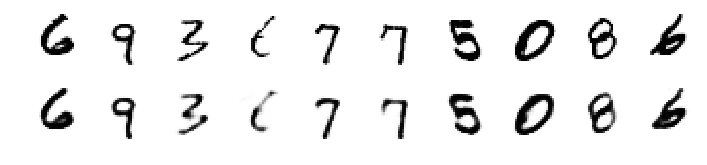

In [377]:
n_digits = 10

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Random Encodings

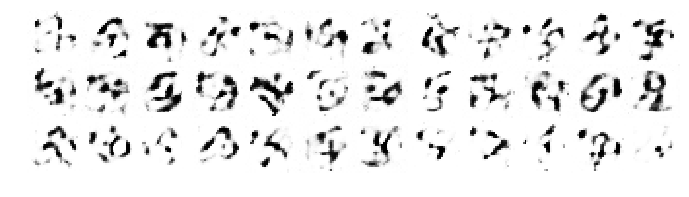

In [378]:
rows = 3
cols = 12
n_digits = rows * cols

#codings_in = noise = np.random.uniform(0, 1, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 4, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

### Encoding Distributions

In [379]:
X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

60000/60000 [==============================] - 2s 37us/step
(60000, 30)


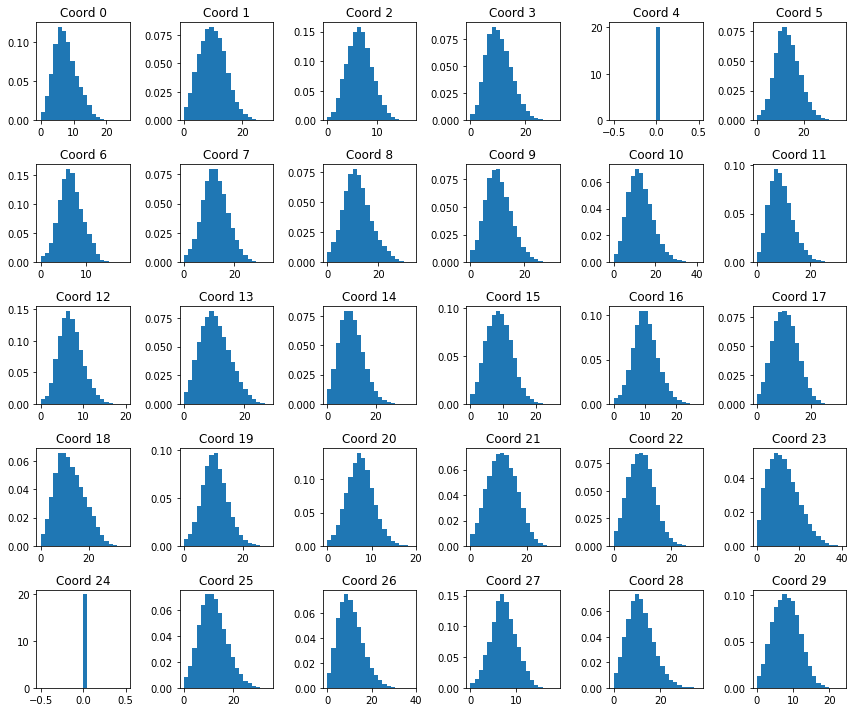

In [380]:
showAll = True

coord_indeces = np.array([
    [  0,  1,  2,  3,  6, 14],
    [ 19, 21, 23, 24, 25, 31]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### PCA

In [483]:
from sklearn.decomposition import PCA

n_points = 5000

X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch, verbose=True)
print(X_enc.shape)

pca = PCA(n_components=2)
X2d = pca.fit_transform(X_enc)
print(X2d.shape)

5000/5000 [==============================] - 0s 98us/step
(5000, 16)
(5000, 2)


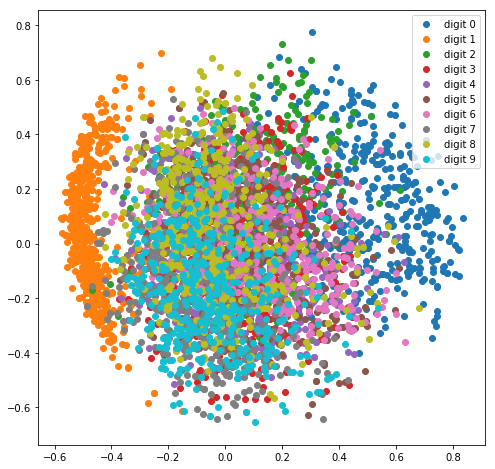

In [484]:
index_list = []
for i in range(10):
    index_list.append(y_batch == i)

plt.figure(figsize=(8,8))
for i in range(10):
    plt.scatter(
        X2d[:, 0][index_list[i]], 
        X2d[:, 1][index_list[i]], 
        cmap=y_batch[index_list[i]], 
        marker='o', label=str('digit ' + str(i))
    )

plt.legend()
plt.show()

## Dense Model `k_auto2`

Same as `k_auto0` but with NO activation at output.

In [1145]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.core import Activation, Dense, Flatten, Reshape
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization

n_codings = 20
model_name = 'k_auto2'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

In [414]:
K.clear_session()
n_inputs = height * width * channels


# Build the encoder part of the model
#
encoder = Sequential(name="encoder")

encoder.add(Flatten(input_shape=(height, width, channels, ), name="input"))
encoder.add(Dense(units=250))
encoder.add(Activation('relu'))
#encoder.add(LeakyReLU(alpha=0.05))

encoder.add(Dense(units=n_codings, name='codings')) # Codings layer - no activation

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               196250    
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
codings (Dense)              (None, 20)                5020      
Total params: 201,270
Trainable params: 201,270
Non-trainable params: 0
_________________________________________________________________


In [415]:
# Build the decoder part of the model
#
n_outputs = n_inputs

decoder = Sequential(name="decoder")

decoder.add(Dense(units=320, input_shape=(n_codings,), name='codings_in'))
decoder.add(Activation('relu'))

decoder.add(Dense(units=n_outputs))
decoder.add(Activation('sigmoid'))

decoder.add(Reshape(target_shape=(height,width,channels), name='output'))

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
codings_in (Dense)           (None, 320)               6720      
_________________________________________________________________
activation_2 (Activation)    (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               251664    
_________________________________________________________________
activation_3 (Activation)    (None, 784)               0         
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 258,384
Trainable params: 258,384
Non-trainable params: 0
_________________________________________________________________


In [416]:
# Stack the two together
#
# NOTE: this could have all been done in a single sequential model, but I chose
# this approach to be able to feed random values into the decoder and see what happens
#
model = Sequential()
model.add(encoder)
model.add(decoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 20)                201270    
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         258384    
Total params: 459,654
Trainable params: 459,654
Non-trainable params: 0
_________________________________________________________________


### Optimizer

In [417]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta(lr=0.15)


encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.compile(loss='mean_squared_error', optimizer=optimizer)

### Train / Save / Restore

In [418]:
epochs = 10
batch_size = 200

history = model.fit(
    X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

score = model.evaluate(X_test, X_test, verbose=1)
print("Test score:", score)

Epoch 1/10
60000/60000 [==============================] - 2s 42us/step - loss: 0.0471
Epoch 2/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.0193
Epoch 3/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.0149
Epoch 4/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.0132
Epoch 5/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.0122
Epoch 6/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.0114
Epoch 7/10
60000/60000 [==============================] - 2s 31us/step - loss: 0.0109
Epoch 8/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.0104
Epoch 9/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.0100
Epoch 10/10
10000/10000 [==============================] - 1s 55us/step
Test score: 0.009518941607326269


In [420]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

In [1146]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')
model= load_model(model_file + '.h5')

### Reconstruction Output

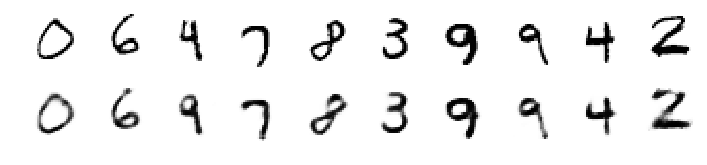

In [1147]:
n_digits = 10

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Random Encodings

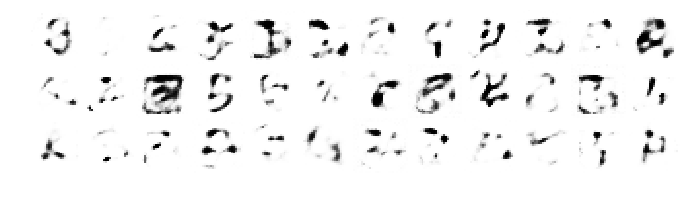

In [1148]:
rows = 3
cols = 12
n_digits = rows * cols

#codings_in = noise = np.random.uniform(0, 1, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 5, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

### Encoding Distributions

In [1149]:
X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

60000/60000 [==============================] - 3s 55us/step
(60000, 20)


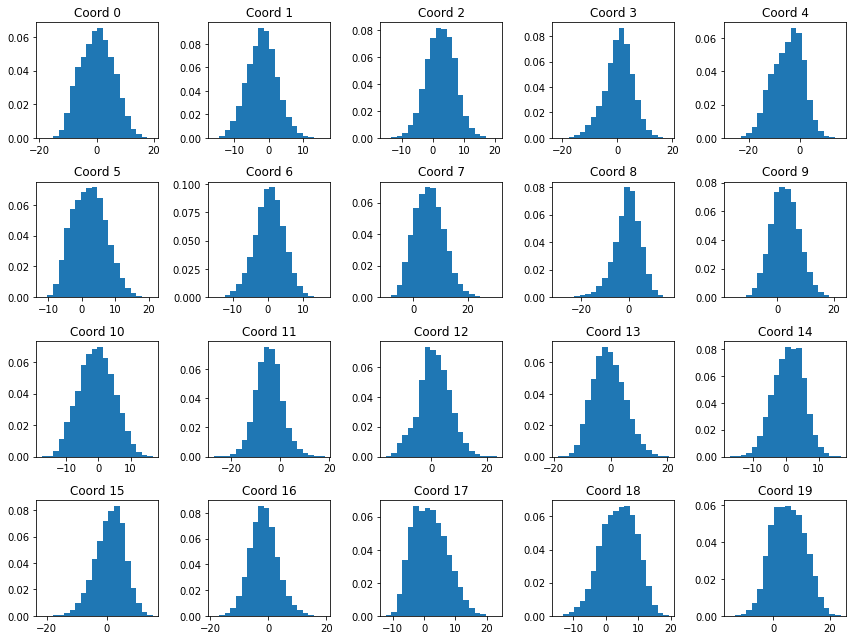

In [1150]:
showAll = True

coord_indeces = np.array([
    [  0,  1,  2,  3,  6, 14],
    [ 19, 21, 23, 24, 25, 31]
])

if showAll:
    n_cols = 5
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### PCA

In [1151]:
from sklearn.decomposition import PCA

n_points = 3000

X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch, verbose=True)
print(X_enc.shape)

pca = PCA(n_components=2)
X2d = pca.fit_transform(X_enc)
print(X2d.shape)

3000/3000 [==============================] - 0s 50us/step
(3000, 20)
(3000, 2)


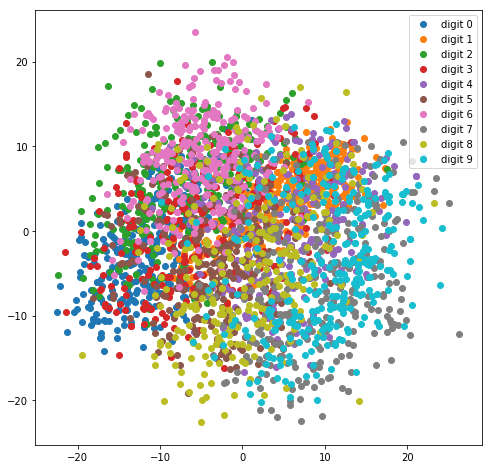

In [1152]:
index_list = []
for i in range(10):
    index_list.append(y_batch == i)

plt.figure(figsize=(8,8))
for i in range(10):
    plt.scatter(
        X2d[:, 0][index_list[i]], 
        X2d[:, 1][index_list[i]], 
        cmap=y_batch[index_list[i]], 
        marker='o', label=str('digit ' + str(i))
    )

plt.legend()
plt.show()

## Dense Model `k_auto3`

Same as `k_auto2` but trained with cross-entropy instead of MSE.

In [1227]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.core import Activation, Dense, Flatten, Reshape
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization

n_codings = 30
model_name = 'k_auto3'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

In [1228]:
K.clear_session()
n_inputs = height * width * channels


# Build the encoder part of the model
#
encoder = Sequential(name="encoder")

encoder.add(Flatten(input_shape=(height, width, channels, ), name="input"))
encoder.add(Dense(units=250))
encoder.add(Activation('relu'))
#encoder.add(LeakyReLU(alpha=0.05))

encoder.add(Dense(units=n_codings))
encoder.add(Activation('relu', name='codings'))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               196250    
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                7530      
_________________________________________________________________
codings (Activation)         (None, 30)                0         
Total params: 203,780
Trainable params: 203,780
Non-trainable params: 0
_________________________________________________________________


In [1229]:
# Build the decoder part of the model
#
n_outputs = n_inputs

decoder = Sequential(name="decoder")

decoder.add(Dense(units=320, input_shape=(n_codings,), name='codings_in'))
decoder.add(Activation('relu'))

decoder.add(Dense(units=n_outputs))
decoder.add(Activation('sigmoid'))

decoder.add(Reshape(target_shape=(height,width,channels), name='output'))

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
codings_in (Dense)           (None, 320)               9920      
_________________________________________________________________
activation_2 (Activation)    (None, 320)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               251664    
_________________________________________________________________
activation_3 (Activation)    (None, 784)               0         
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 261,584
Trainable params: 261,584
Non-trainable params: 0
_________________________________________________________________


In [1230]:
# Stack the two together
#
# NOTE: this could have all been done in a single sequential model, but I chose
# this approach to be able to feed random values into the decoder and see what happens
#
model = Sequential()
model.add(encoder)
model.add(decoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 30)                203780    
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         261584    
Total params: 465,364
Trainable params: 465,364
Non-trainable params: 0
_________________________________________________________________


### Optimizer

In [1231]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta(lr=0.15)


encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.compile(loss='binary_crossentropy', optimizer=optimizer)

### Train / Save / Restore

In [1232]:
epochs = 10
batch_size = 200

history = model.fit(
    X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

score = model.evaluate(X_test, X_test, verbose=1)
print("Test score:", score)

Epoch 1/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.1892
Epoch 2/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.1122
Epoch 3/10
60000/60000 [==============================] - 2s 41us/step - loss: 0.1017
Epoch 4/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.0976
Epoch 5/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.0951
Epoch 6/10
60000/60000 [==============================] - 2s 40us/step - loss: 0.0931
Epoch 7/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.0915
Epoch 8/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.0902
Epoch 9/10
60000/60000 [==============================] - 2s 39us/step - loss: 0.0890
Epoch 10/10
10000/10000 [==============================] - 1s 66us/step
Test score: 0.08673948206901551


In [1233]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

In [1190]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')
model= load_model(model_file + '.h5')

### Reconstruction Output

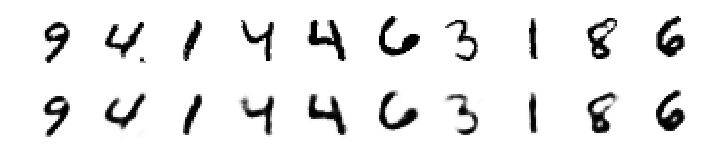

In [1234]:
n_digits = 10

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Random Encodings

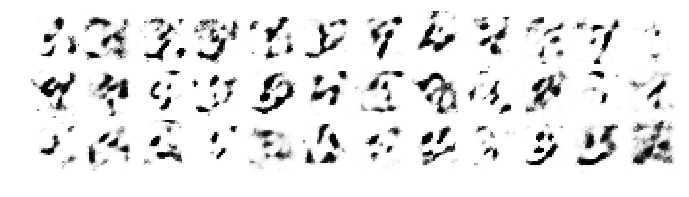

In [1235]:
rows = 3
cols = 12
n_digits = rows * cols

#codings_in = noise = np.random.uniform(0, 1, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 5, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

### Encoding Distributions

In [1241]:
X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

60000/60000 [==============================] - 2s 36us/step
(60000, 30)


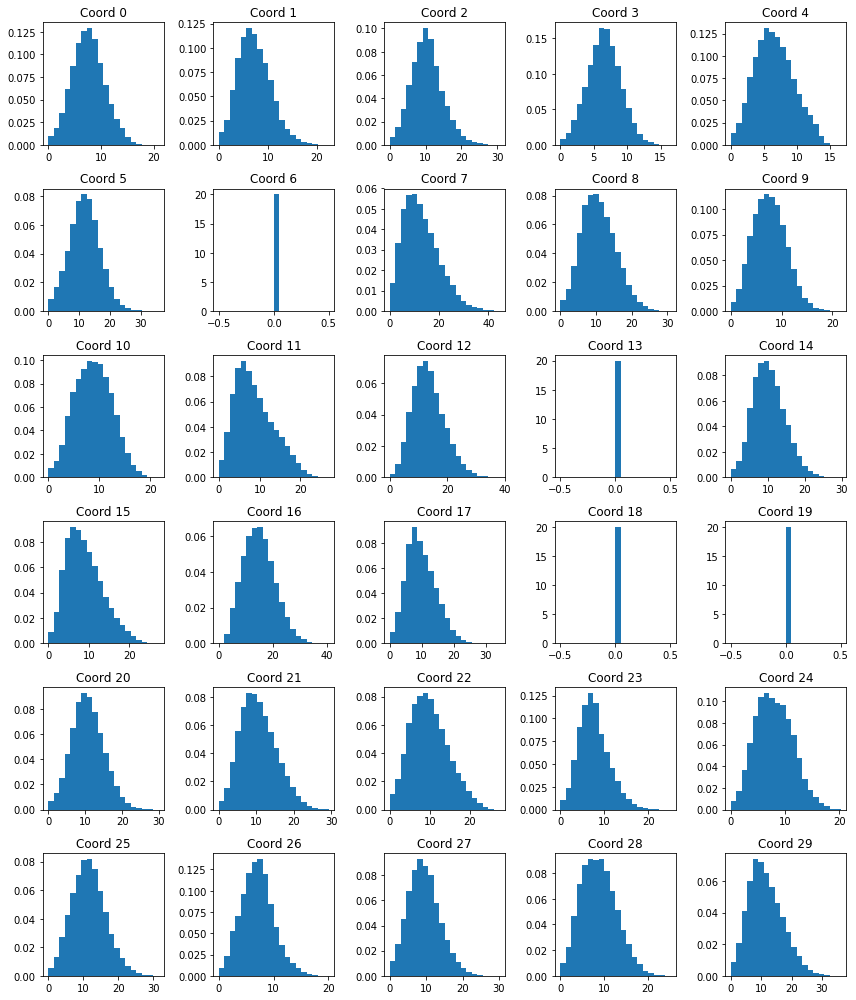

In [1242]:
showAll = True

coord_indeces = np.array([
    [  0,  1,  2,  3,  6, 14],
    [ 19, 21, 23, 24, 25, 31]
])

if showAll:
    n_cols = 5
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### PCA

In [1243]:
from sklearn.decomposition import PCA

n_points = 3000

X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch, verbose=True)
print(X_enc.shape)

pca = PCA(n_components=2)
X2d = pca.fit_transform(X_enc)
print(X2d.shape)

3000/3000 [==============================] - 0s 39us/step
(3000, 30)
(3000, 2)


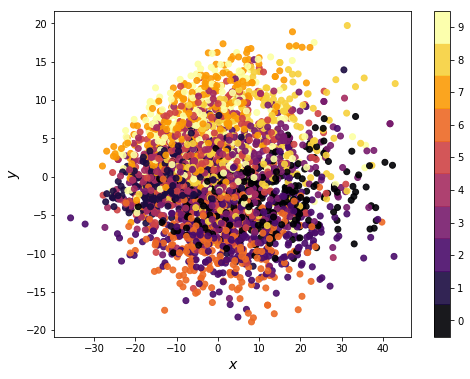

In [1244]:
fig = plt.figure(figsize=(8,6))

colors = y_batch
colormap = plt.get_cmap('inferno', 10)

p = plt.scatter(X2d[:, 0], X2d[:, 1],
        c=colors, cmap=colormap, marker='o', alpha=0.9
)

plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
plt.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5 * (9.0/10.0), 1.5*.... etc
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

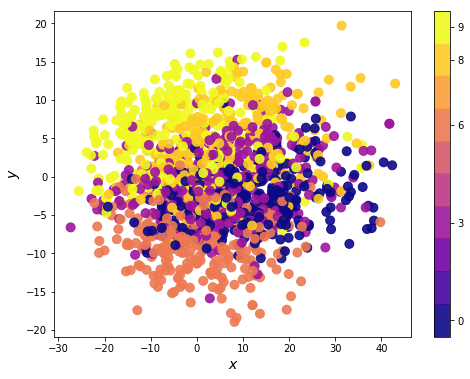

In [1245]:
digit_list = [0, 3, 6, 8, 9]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(8,6))

colors = y_batch[indeces]
colormap = plt.get_cmap('plasma', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=80, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

## Conv Model `k_auto_conv0`

Instead of using dense layers, it is common to use convolutional layers when working with images:

<img src="./images/autoencoder_convolutional.png" style="width:50%">

In [428]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.core import Activation, Dense, Flatten, Reshape
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

n_codings = 30
model_name = 'k_auto_conv0'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

In [432]:
K.clear_session()
n_inputs = height * width * channels


# Build the encoder part of the model
#
encoder = Sequential(name="encoder")

encoder.add(
    Conv2D(input_shape=(height,width,channels), 
           filters=6, kernel_size=5, strides=1, padding='same')
)
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2, 2)))

encoder.add(Conv2D(filters=12, kernel_size=5, strides=1, padding='same'))
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2, 2)))

encoder.add(Flatten())

# the loss will now decrease without an activation at the codings layer
encoder.add(Dense(units=n_codings))
encoder.add(Activation('tanh', name='codings'))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 12)        1812      
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 12)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 12)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 588)               0         
__________

In [435]:
print(encoder.layers[-1].output_shape[1:])
print(encoder.layers[-2].output_shape[1:])
print(encoder.layers[-3].output_shape[1:])
print(encoder.layers[-4].output_shape[1:])

(30,)
(30,)
(588,)
(7, 7, 12)


In [436]:
# Build the decoder part of the model
#
n_outputs = n_inputs

decoder = Sequential(name="decoder")

h0 = encoder.layers[-4].output_shape[1]
w0 = encoder.layers[-4].output_shape[2]
feats = encoder.layers[-4].output_shape[3]
decoder.add(Dense(input_shape=(n_codings,), units=h0*w0*feats))
decoder.add(Activation('relu'))
decoder.add(Reshape(target_shape=(h0, w0, feats,)))

decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=8, kernel_size=3, strides=1, padding='same'))
decoder.add(Activation('relu'))

decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=4, kernel_size=5, strides=1, padding='same'))
decoder.add(Activation('relu'))

decoder.add(Conv2D(filters=1, kernel_size=7, strides=1, padding='same'))
decoder.add(Activation('sigmoid', name='output'))

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 588)               18228     
_________________________________________________________________
activation_3 (Activation)    (None, 588)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 12)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 12)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 8)         872       
_________________________________________________________________
activation_4 (Activation)    (None, 14, 14, 8)         0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 8)         0         
__________

In [437]:
# Stack the two together
#
# NOTE: this could have all been done in a single sequential model, but I chose
# this approach to be able to feed random values into the decoder and see what happens
#
model = Sequential()
model.add(encoder)
model.add(decoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 30)                19638     
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         20101     
Total params: 39,739
Trainable params: 39,739
Non-trainable params: 0
_________________________________________________________________


### Optimizer

In [438]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta(lr=0.15)


encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.compile(loss='mean_squared_error', optimizer=optimizer)

### Train / Save / Restore

In [439]:
epochs = 15
batch_size = 200

history = model.fit(
    X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

score = model.evaluate(X_test, X_test, verbose=1)
print("Test score:", score)

Epoch 1/15
60000/60000 [==============================] - 7s 109us/step - loss: 0.0716
Epoch 2/15
60000/60000 [==============================] - 6s 93us/step - loss: 0.0445
Epoch 3/15
60000/60000 [==============================] - 6s 93us/step - loss: 0.0216
Epoch 4/15
60000/60000 [==============================] - 6s 93us/step - loss: 0.0152
Epoch 5/15
60000/60000 [==============================] - 6s 94us/step - loss: 0.0125
Epoch 6/15
60000/60000 [==============================] - 6s 93us/step - loss: 0.0110
Epoch 7/15
60000/60000 [==============================] - 6s 94us/step - loss: 0.0099
Epoch 8/15
60000/60000 [==============================] - 6s 94us/step - loss: 0.0092
Epoch 9/15
60000/60000 [==============================] - 6s 94us/step - loss: 0.0086
Epoch 10/15
60000/60000 [==============================] - 6s 94us/step - loss: 0.0081
Epoch 11/15
60000/60000 [==============================] - 6s 94us/step - loss: 0.0078
Epoch 12/15
60000/60000 [==========================

In [440]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

In [1140]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')
model= load_model(model_file + '.h5')

### Reconstruction Output

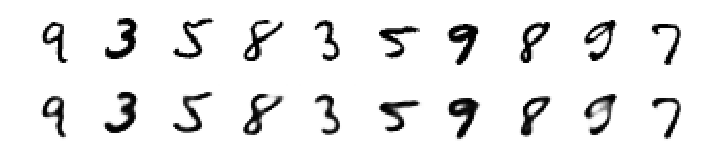

In [442]:
n_digits = 10

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

As an exercise, try to modify this model. Some things you can try:
* change the # of  feature maps
* make the model deeper

### Random Encodings

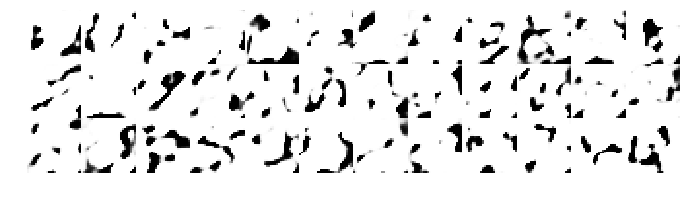

In [443]:
rows = 3
cols = 12
n_digits = rows * cols

#codings_in = noise = np.random.uniform(0, 1, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

### Encoding Distributions

In [1143]:
X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

60000/60000 [==============================] - 4s 72us/step
(60000, 16)


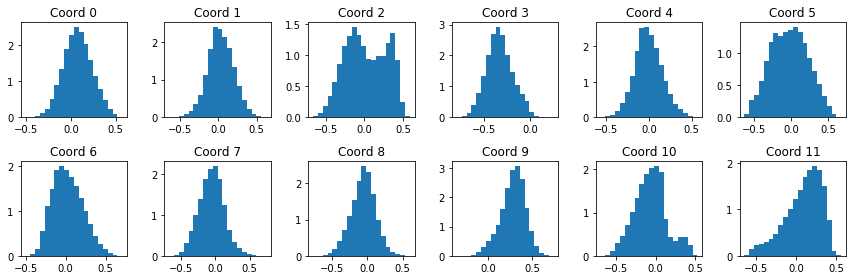

In [1144]:
showAll = True

coord_indeces = np.array([
    [  0,  1,  2,  3,  6, 14],
    [ 19, 21, 23, 24, 25, 31]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### PCA

In [1141]:
from sklearn.decomposition import PCA

n_points = 1000

X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch, verbose=True)
print(X_enc.shape)

pca = PCA(n_components=2)
X2d = pca.fit_transform(X_enc)
print(X2d.shape)

1000/1000 [==============================] - 0s 368us/step
(1000, 16)
(1000, 2)


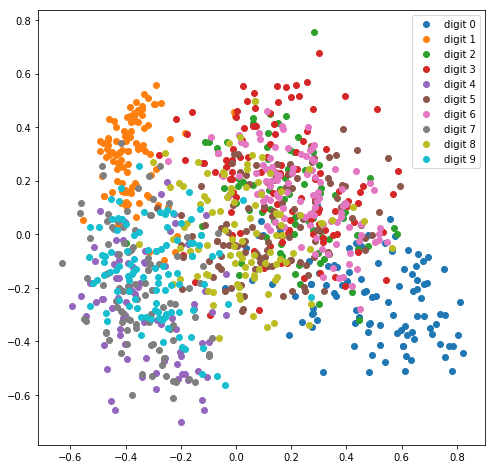

In [1142]:
index_list = []
for i in range(10):
    index_list.append(y_batch == i)

plt.figure(figsize=(8,8))
for i in range(10):
    plt.scatter(
        X2d[:, 0][index_list[i]], 
        X2d[:, 1][index_list[i]], 
        cmap=y_batch[index_list[i]], 
        marker='o', label=str('digit ' + str(i))
    )

plt.legend()
plt.show()

## Conv Model `k_auto_conv1`

In [514]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers.core import Activation, Dense, Flatten, Reshape
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

n_codings = 16
model_name = 'k_auto_conv1'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

In [495]:
K.clear_session()
n_inputs = height * width * channels


# Build the encoder part of the model
#
encoder = Sequential(name="encoder")

encoder.add(Conv2D(input_shape=(height,width,channels),
                   filters=4, kernel_size=5, strides=1, padding='same')
)
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2, 2)))

encoder.add(Conv2D(filters=8, kernel_size=5, strides=1, padding='same'))
encoder.add(Activation('relu'))
encoder.add(MaxPooling2D(pool_size=(2, 2)))

encoder.add(Flatten())

encoder.add(Dense(units=150))
encoder.add(Activation('relu'))

encoder.add(Dense(units=n_codings))
encoder.add(Activation('tanh', name='output'))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 4)         104       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 4)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 8)         808       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
__________

In [498]:
print(encoder.layers[-1].output_shape[1:])
print(encoder.layers[-2].output_shape)
print(encoder.layers[-3].output_shape)
print(encoder.layers[-4].output_shape)
print(encoder.layers[-5].output_shape)
print(encoder.layers[-6].output_shape)

(16,)
(None, 16)
(None, 150)
(None, 150)
(None, 392)
(None, 7, 7, 8)


In [499]:
# Build the decoder part of the model
#
n_outputs = n_inputs

decoder = Sequential(name="decoder")

decoder.add(Dense(input_shape=(n_codings, ), units=120, name='codings_in'))
decoder.add(Activation('relu'))
decoder.add(Dense(units=320))
decoder.add(Activation('relu'))

h0 = encoder.layers[-6].output_shape[1]
w0 = encoder.layers[-6].output_shape[2]
feats = 16
decoder.add(Dense(units=h0*w0*feats))
decoder.add(Activation('relu'))

decoder.add(Reshape(target_shape=(h0, w0, feats,)))

decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=8, kernel_size=5, strides=1, padding='same'))
decoder.add(Activation('relu'))

decoder.add(UpSampling2D(size=(2,2)))
decoder.add(Conv2D(filters=4, kernel_size=6, strides=1, padding='same'))
decoder.add(Activation('relu'))

decoder.add(Conv2D(filters=1, kernel_size=7, strides=1, padding='same'))
decoder.add(Activation('sigmoid', name='output'))

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
codings_in (Dense)           (None, 120)               2040      
_________________________________________________________________
activation_4 (Activation)    (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 320)               38720     
_________________________________________________________________
activation_5 (Activation)    (None, 320)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 784)               251664    
_________________________________________________________________
activation_6 (Activation)    (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 16)          0         
__________

In [500]:
# Stack the two together
#
# NOTE: this could have all been done in a single sequential model, but I chose
# this approach to be able to feed random values into the decoder and see what happens
#
model = Sequential()
model.add(encoder)
model.add(decoder)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 16)                62278     
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         296985    
Total params: 359,263
Trainable params: 359,263
Non-trainable params: 0
_________________________________________________________________


### Optimizer

In [501]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta(lr=0.15)


encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.compile(loss='mean_squared_error', optimizer=optimizer)

### Train / Save / Restore

In [502]:
epochs = 20
batch_size = 150

history = model.fit(
    X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

score = model.evaluate(X_test, X_test, verbose=1)
print("Test score:", score)

Epoch 1/20
60000/60000 [==============================] - 10s 163us/step - loss: 0.0565
Epoch 2/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.0272
Epoch 3/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.0216
Epoch 4/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.0188
Epoch 5/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.0170
Epoch 6/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.0157
Epoch 7/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.0144
Epoch 8/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.0135
Epoch 9/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.0129
Epoch 10/20
60000/60000 [==============================] - 9s 145us/step - loss: 0.0125
Epoch 11/20
60000/60000 [==============================] - 9s 144us/step - loss: 0.0121
Epoch 12/20
60000/60000 [===============

In [503]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

In [504]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')
model= load_model(model_file + '.h5')

### Reconstruction Output

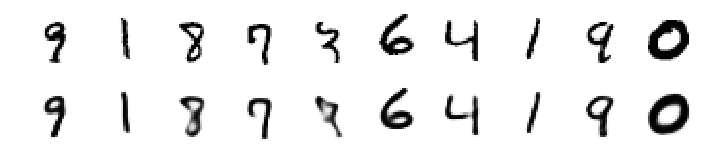

In [505]:
n_digits = 10

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Random Encodings

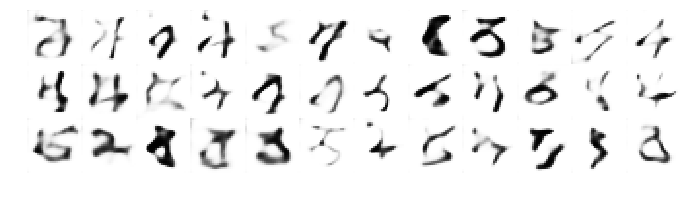

In [506]:
rows = 3
cols = 12
n_digits = rows * cols

#codings_in = noise = np.random.uniform(0, 1, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 0.2, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

### Encoding Distributions

In [507]:
X_encoded = encoder.predict(X_train, verbose=True)
print(X_encoded.shape)

60000/60000 [==============================] - 3s 54us/step
(60000, 16)


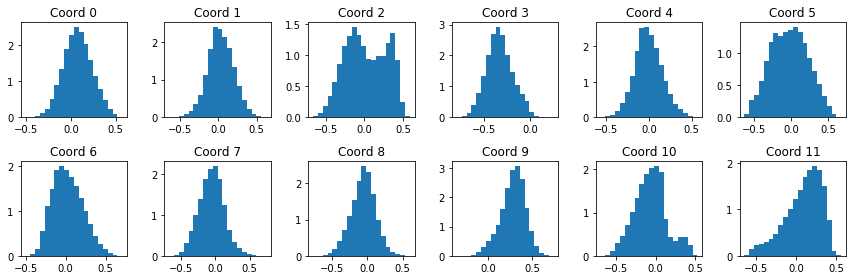

In [508]:
showAll = True

coord_indeces = np.array([
    [  0,  1,  2,  3,  6, 14],
    [ 19, 21, 23, 24, 25, 31]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### PCA

In [511]:
from sklearn.decomposition import PCA

n_points = 2000

X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch, verbose=True)
print(X_enc.shape)

pca = PCA(n_components=2)
X2d = pca.fit_transform(X_enc)
print(X2d.shape)

2000/2000 [==============================] - 0s 58us/step
(2000, 16)
(2000, 2)


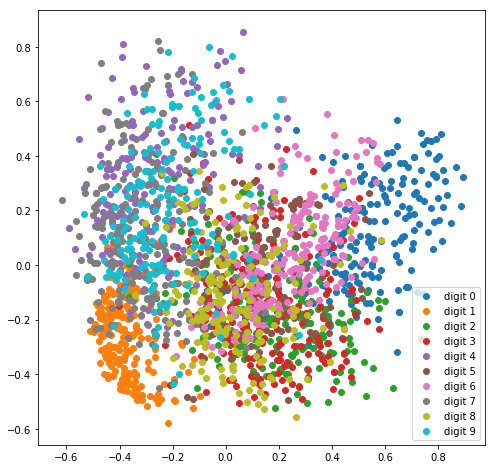

In [512]:
index_list = []
for i in range(10):
    index_list.append(y_batch == i)

plt.figure(figsize=(8,8))
for i in range(10):
    plt.scatter(
        X2d[:, 0][index_list[i]], 
        X2d[:, 1][index_list[i]], 
        cmap=y_batch[index_list[i]], 
        marker='o', label=str('digit ' + str(i))
    )

plt.legend()
plt.show()

## PCA visualization

### 2D

In [1197]:
from keras.models import load_model

model_name = 'k_auto3'
#model_name = 'k_auto_conv1'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')
model= load_model(model_file + '.h5')

n_codings = encoder.layers[-1].output_shape[1]
print(n_codings)

30


In [1198]:
n_points = 3000
X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch)

In [1199]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X2d.shape)

Compressed (3000, 30) into (3000, 2)


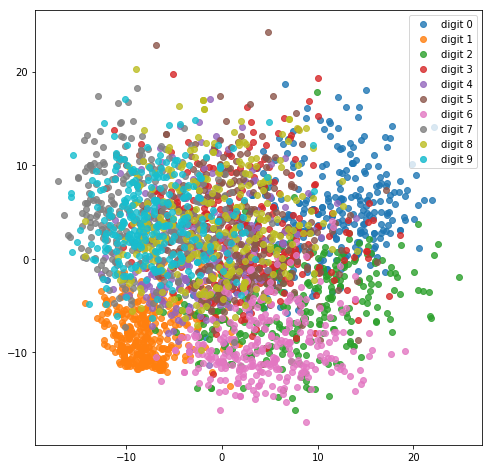

In [1200]:
index_list = []
for i in range(10):
    index_list.append(y_batch == i)

plt.figure(figsize=(8,8))
for i in range(10):
    plt.scatter(
        X2d[:, 0][index_list[i]], 
        X2d[:, 1][index_list[i]], 
        cmap=y_batch[index_list[i]], 
        label=str('digit ' + str(i)), marker='o', alpha=0.8
    )
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')
plt.legend()
plt.show()

Color bar visualization looks better than legend.

Possible `colormap` values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

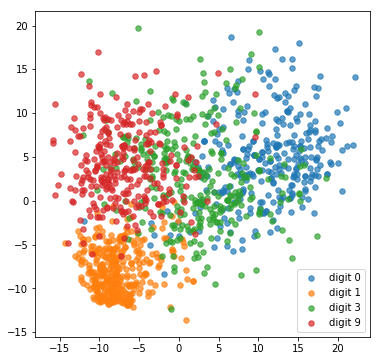

In [1202]:
digit_list = [0, 1, 3, 9]

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)

plt.figure(figsize=(6,6))
for i in range(len(index_list)):
    plt.scatter(X2d[index_list[i], 0], X2d[index_list[i], 1], 
        s=30, cmap=y_batch[index_list[i]], marker='o', alpha=0.7,
        label=str('digit ' + str(digit_list[i])), 
    )
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')
plt.legend()
plt.show()

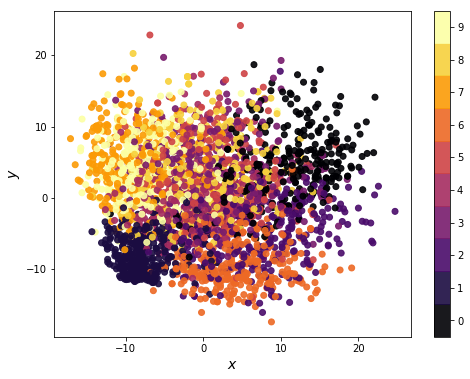

In [1203]:
fig = plt.figure(figsize=(8,6))

colors = y_batch
colormap = plt.get_cmap('inferno', 10)

p = plt.scatter(X2d[:, 0], X2d[:, 1],
        c=colors, cmap=colormap, marker='o', alpha=0.9
)

plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
plt.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5 * (9.0/10.0), 1.5*.... etc
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

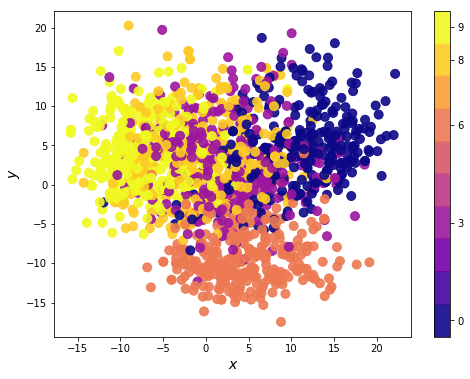

In [1207]:
digit_list = [0, 3,6,8, 9]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(8,6))

colors = y_batch[indeces]
colormap = plt.get_cmap('plasma', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=80, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

`KernelPCA` gives us different kernels to work with. Here are some common kernels:
* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a}^T - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

Options:
* `n_components` : int, default=None
* `kernel=` : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
* `gamma` : float, default=1/n_features
* `degree` : int, default=3 (for poly kernels)
* `coef0` : float, default=1 (independent term in poly and sigmoid kernels, ignored by other kernels)


In [1225]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.25, degree=2)
X2d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X2d.shape)

Compressed (3000, 30) into (3000, 2)


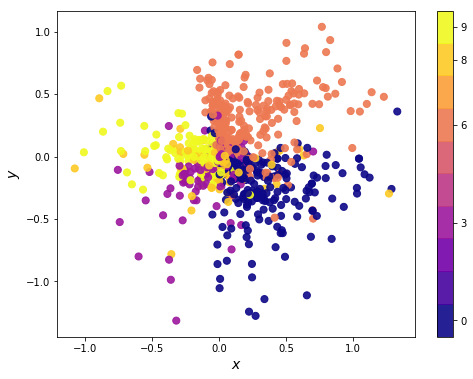

In [1226]:
digit_list = [0, 3, 6, 8, 9]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(8,6))

colors = y_batch[indeces]
colormap = plt.get_cmap('plasma', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=50, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

### 3D

In [1124]:
from keras.models import load_model

#model_name = 'k_auto1'
model_name = 'k_auto_conv1'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')
model= load_model(model_file + '.h5')

n_codings = encoder.layers[-1].output_shape[1]
print(n_codings)

16


In [1133]:
n_points = 3000
X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch)

In [1134]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X3d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X3d.shape)

Compressed (3000, 16) into (3000, 3)


Possible `colormap` values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

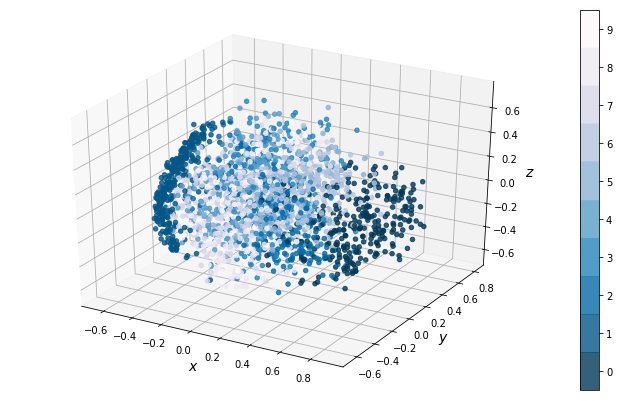

In [1135]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,7))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch# / 9.0
colormap = plt.get_cmap('PuBu_r', 10)

p = ax3d.scatter3D(
        X3d[:, 0], X3d[:, 1], X3d[:, 2],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)

ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5 * (9.0/10.0), 1.5*.... etc
tick_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

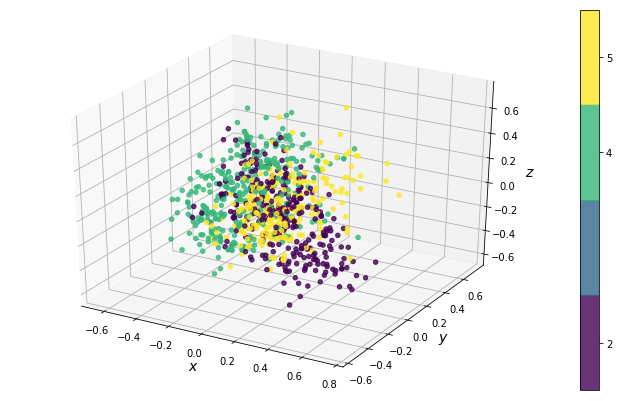

In [1136]:
from mpl_toolkits.mplot3d import Axes3D

digit_list = [2, 4, 5]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

fig = plt.figure(figsize=(12,7))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch[indeces]
colormap = plt.get_cmap('viridis', n_bins)

p = ax3d.scatter3D(X3d[:, 0][indeces], X3d[:, 1][indeces], X3d[:, 2][indeces],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)
ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

`KernelPCA` gives us different kernels to work with. Here are some common kernels:
* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a}^T - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

Options:
* `n_components` : int, default=None
* `kernel=` : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
* `gamma` : float, default=1/n_features
* `degree` : int, default=3 (for poly kernels)
* `coef0` : float, default=1 (independent term in poly and sigmoid kernels, ignored by other kernels)


In [1137]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=3, kernel='cosine', gamma=0.15, degree=-1)
X3d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X3d.shape)

Compressed (3000, 16) into (3000, 3)


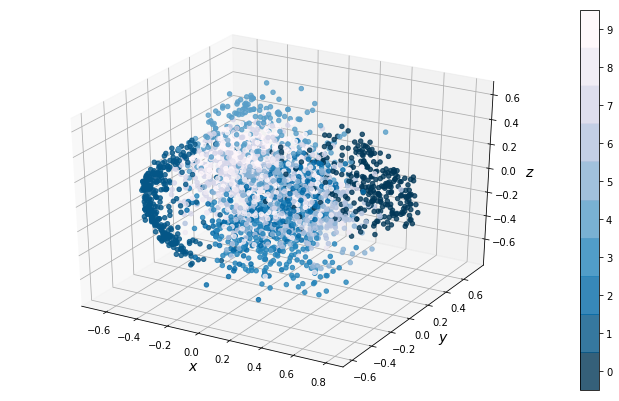

In [1138]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,7))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch# / 9.0
colormap = plt.get_cmap('PuBu_r', 10)

p = ax3d.scatter3D(X3d[:, 0], X3d[:, 1], X3d[:, 2],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)

ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5 * (9.0/10.0), 1.5*.... etc
tick_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

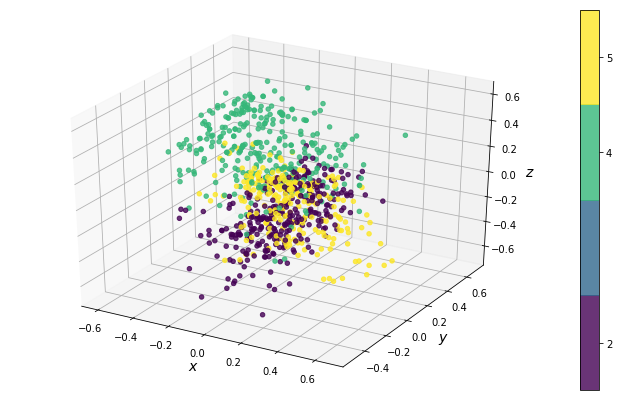

In [1139]:
from mpl_toolkits.mplot3d import Axes3D

digit_list = [2, 4, 5]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

fig = plt.figure(figsize=(12,7))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch[indeces]
colormap = plt.get_cmap('viridis', n_bins)

p = ax3d.scatter3D(X3d[:, 0][indeces], X3d[:, 1][indeces], X3d[:, 2][indeces],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)
ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

# VAE (MNIST)

## Data Import

In [4]:
from keras.datasets import mnist
from keras.utils import np_utils, plot_model, to_categorical

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape)

height = X_train.shape[1]
width = X_train.shape[2]
channels = 1

X_train = X_train.astype(np.float32) / 255.0 #ensure pixel values are between 0 and 1
X_train = X_train.reshape((X_train.shape[0], height, width, channels))
X_test = X_test.astype(np.float32) / 255.0 #ensure pixel values are between 0 and 1
X_test = X_test.reshape((X_test.shape[0], height, width, channels))
X_train_cond = to_categorical(y_train)
X_test_cond = to_categorical(y_test)

# Run this if you don't use the whole training set
if False:
    m = 10000
    random_indeces = np.random.randint(0, X_train.shape[0], np.min(m, X_train.shape[0]))
    X_train = X_train[random_indeces]

print(X_train.shape, y_train.shape, X_train_cond.shape)
print(X_test.shape, y_test.shape, X_test_cond.shape)

(60000, 28, 28) (60000,)
(60000, 28, 28, 1) (60000,) (60000, 10)
(10000, 28, 28, 1) (10000,) (10000, 10)


## VAE `k_auto_var0`

Dense model.

In [1329]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

n_codings = 24
model_name = 'k_auto_var0'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

In [1301]:
K.clear_session()
n_inputs = height * width * channels

def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    return param_0 + param_1 * normal_01
    #return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
inputs = Input(shape=(height, width, channels,), name='inputs')
inputs_flat = Flatten()(inputs)
hidden1 = Dense(units=250, activation='relu')(inputs_flat)

param_0 = Dense(n_codings, name='param_0')(hidden1)
param_1 = Dense(n_codings, name='param_1')(hidden1)
#param_2 = Dense(n_codings, name='param_2')(hidden1) #to play around with

# We feed the param_0 and param_1 into the Lambda layer, whose function is to 
# tranform a random uniform(0,1) variable by applying the parameters
codings = Lambda(sampling, output_shape=(n_codings,), name='codings')([param_0, param_1])

encoder = Model(inputs, [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           inputs[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 250)          196250      flatten_1[0][0]                  
__________________________________________________________________________________________________
param_0 (Dense)                 (None, 24)           6024        dense_1[0][0]                    
__________________________________________________________________________________________________
param_1 (D

In [1302]:
# Build the decoder part of the model
#
n_outputs = n_inputs

latent_inputs = Input(shape=(n_codings,), name='latent_inputs')
hidden2 = Dense(320, activation='relu')(latent_inputs)
output_flat = Dense(units=n_outputs, activation='sigmoid')(hidden2)

output = Reshape(target_shape=(height,width,channels,), name='output')(output_flat)

decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 320)               8000      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               251664    
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 259,664
Trainable params: 259,664
Non-trainable params: 0
_________________________________________________________________


In [1319]:
# Stack the two together
#
outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  208298    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         259664    
Total params: 467,962
Trainable params: 467,962
Non-trainable params: 0
_________________________________________________________________


### Loss and Optimizer

In [1320]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 28, 28, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
#dist_loss = 1 + param_1 - K.square(param_0) - K.exp(param_1)
dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.15)

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss([loss])
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 28, 28, 1) (?, 28, 28, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  208298    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         259664    
Total params: 467,962
Trainable params: 467,962
Non-trainable params: 0
_________________________________________________________________


### Train / Save / Restore

In [1321]:
epochs = 30
batch_size = 200

history = model.fit(
    X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

Epoch 1/50
60000/60000 [==============================] - 3s 46us/step - loss: 22.2562
Epoch 2/50
60000/60000 [==============================] - 2s 29us/step - loss: 20.2263
Epoch 3/50
60000/60000 [==============================] - 2s 29us/step - loss: 19.2638
Epoch 4/50
60000/60000 [==============================] - 2s 29us/step - loss: 18.7220
Epoch 5/50
60000/60000 [==============================] - 2s 29us/step - loss: 18.3652
Epoch 6/50
60000/60000 [==============================] - 2s 30us/step - loss: 18.0950
Epoch 7/50
60000/60000 [==============================] - 2s 29us/step - loss: 17.8929
Epoch 8/50
60000/60000 [==============================] - 2s 29us/step - loss: 17.7321
Epoch 9/50
60000/60000 [==============================] - 2s 29us/step - loss: 17.5891
Epoch 10/50
60000/60000 [==============================] - 2s 29us/step - loss: 17.4771
Epoch 11/50
60000/60000 [==============================] - 2s 29us/step - loss: 17.3646
Epoch 12/50
60000/60000 [================

In [1322]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

In [1330]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.compile(loss='binary_crossentropy', optimizer="adam")

### Reconstruction Output

Let's take a look at how well the reconstructions look:

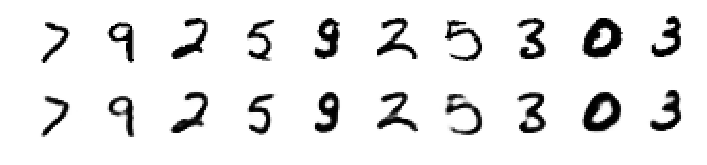

In [1331]:
n_digits = 10

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Encoding Distributions

In [1332]:
encoder_output = encoder.predict(X_test, verbose=True)
print(encoder_output[0].shape)

10000/10000 [==============================] - 1s 55us/step
(10000, 24)


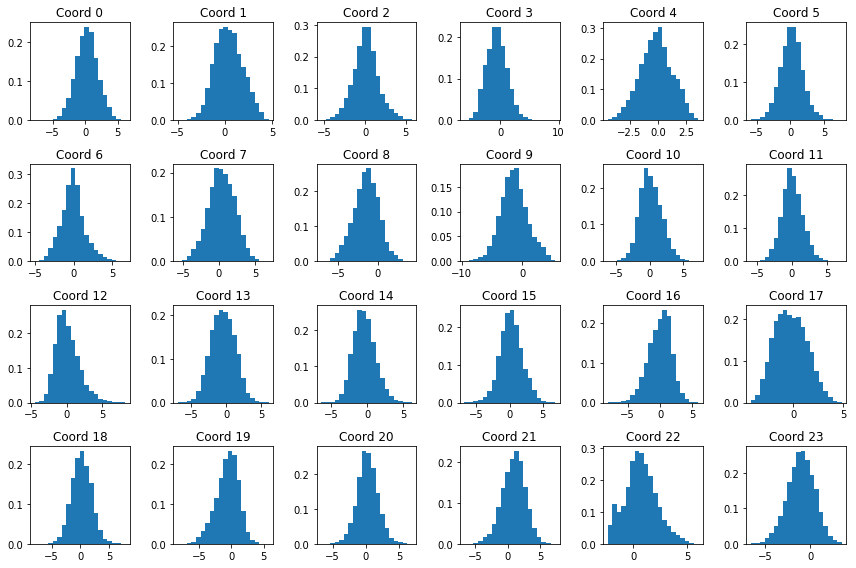

In [1333]:
X_encoded = encoder_output[0]
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 3, 4],
    [ 5, 6, 7, 8, 9]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### Generative

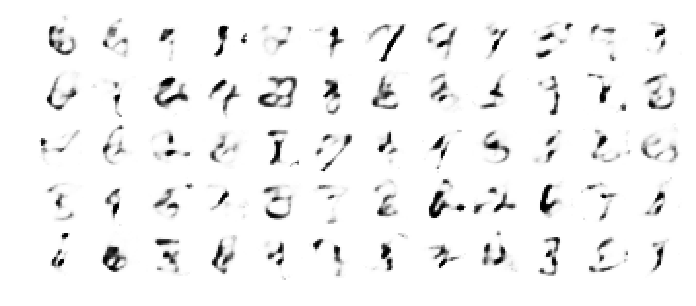

In [1341]:
rows = 5
cols = 12
n_digits = rows * cols

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

## VAE `k_auto_var1`

Dense model using logvar for latent variables.

In [1342]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

n_codings = 24
model_name = 'k_auto_var1'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

In [1343]:
K.clear_session()
n_inputs = height * width * channels

def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    #return param_0 + param_1 * normal_01
    return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
inputs = Input(shape=(height, width, channels,), name='inputs')
inputs_flat = Flatten()(inputs)
hidden1 = Dense(units=250, activation='relu')(inputs_flat)

param_0 = Dense(n_codings, name='param_0')(hidden1)
param_1 = Dense(n_codings, name='param_1')(hidden1)
#param_2 = Dense(n_codings, name='param_2')(hidden1) #to play around with

# We feed the param_0 and param_1 into the Lambda layer, whose function is to 
# tranform a random uniform(0,1) variable by applying the parameters
codings = Lambda(sampling, output_shape=(n_codings,), name='codings')([param_0, param_1])

encoder = Model(inputs, [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           inputs[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 250)          196250      flatten_1[0][0]                  
__________________________________________________________________________________________________
param_0 (Dense)                 (None, 24)           6024        dense_1[0][0]                    
__________________________________________________________________________________________________
param_1 (D

In [1344]:
# Build the decoder part of the model
#
n_outputs = n_inputs

latent_inputs = Input(shape=(n_codings,), name='latent_inputs')
hidden2 = Dense(320, activation='relu')(latent_inputs)
output_flat = Dense(units=n_outputs, activation='sigmoid')(hidden2)
output = Reshape(target_shape=(height,width,channels,), name='output')(output_flat)

decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 320)               8000      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               251664    
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 259,664
Trainable params: 259,664
Non-trainable params: 0
_________________________________________________________________


In [1345]:
# Stack the two together
#
outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  208298    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         259664    
Total params: 467,962
Trainable params: 467,962
Non-trainable params: 0
_________________________________________________________________


### Loss and Optimizer

In [1346]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 28, 28, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
dist_loss = K.square(param_0) + K.exp(param_1) - 1 - param_1
#dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.15)

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 28, 28, 1) (?, 28, 28, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  208298    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         259664    
Total params: 467,962
Trainable params: 467,962
Non-trainable params: 0
_________________________________________________________________


### Train / Save / Restore

In [1347]:
epochs = 30
batch_size = 150

history = model.fit(
    X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

Epoch 1/30
60000/60000 [==============================] - 3s 50us/step - loss: 50.2046
Epoch 2/30
60000/60000 [==============================] - 2s 38us/step - loss: 36.7535
Epoch 3/30
60000/60000 [==============================] - 2s 39us/step - loss: 34.3768
Epoch 4/30
60000/60000 [==============================] - 2s 38us/step - loss: 33.2152
Epoch 5/30
60000/60000 [==============================] - 2s 37us/step - loss: 32.4756
Epoch 6/30
60000/60000 [==============================] - 2s 37us/step - loss: 32.0494
Epoch 7/30
60000/60000 [==============================] - 2s 37us/step - loss: 31.6754
Epoch 8/30
60000/60000 [==============================] - 2s 38us/step - loss: 31.4117
Epoch 9/30
60000/60000 [==============================] - 2s 37us/step - loss: 31.2066
Epoch 10/30
60000/60000 [==============================] - 2s 39us/step - loss: 31.0073
Epoch 11/30
60000/60000 [==============================] - 2s 37us/step - loss: 30.8834
Epoch 12/30
60000/60000 [================

In [1348]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

In [1349]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.compile(loss='binary_crossentropy', optimizer="adam")

### Reconstruction Output

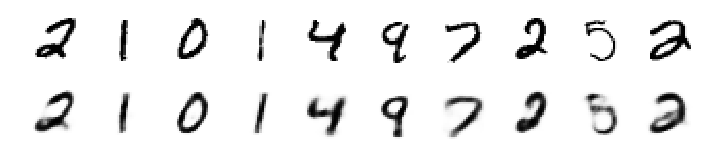

In [1350]:
n_digits = 10

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Encoding Distributions

In [55]:
encoder_output = encoder.predict(X_test, verbose=True)
print(encoder_output[0].shape)

10000/10000 [==============================] - 1s 54us/step
(10000, 24)


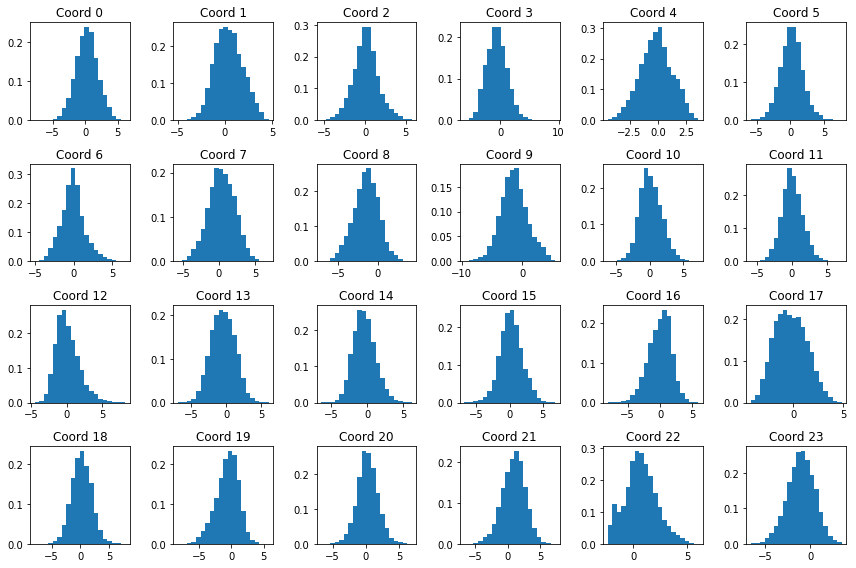

In [1351]:
X_encoded = encoder_output[0]
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 3, 4],
    [ 5, 6, 7, 8, 9]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### Generative

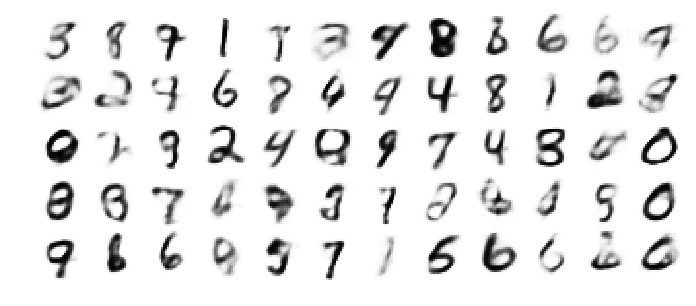

In [1352]:
rows = 5
cols = 12
n_digits = rows * cols

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

## VAE `k_auto_var2`

A deeper model than `k_auto_var1`, still using logvar

In [1353]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

n_codings = 24
model_name = 'k_auto_var2'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

In [1354]:
K.clear_session()
n_inputs = height * width * channels

def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    #return param_0 + param_1 * normal_01
    return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
inputs = Input(shape=(height, width, channels,), name='inputs')
inputs_flat = Flatten()(inputs)
hidden1 = Dense(units=360, activation='relu')(inputs_flat)
hidden2 = Dense(units=180, activation='relu')(hidden1)

param_0 = Dense(n_codings, name='param_0')(hidden2)
param_1 = Dense(n_codings, name='param_1')(hidden2)
#param_2 = Dense(n_codings, name='param_2')(hidden1) #to play around with

# We feed the param_0 and param_1 into the Lambda layer, whose function is to 
# tranform a random uniform(0,1) variable by applying the parameters
codings = Lambda(sampling, output_shape=(n_codings,), name='codings')([param_0, param_1])

encoder = Model(inputs, [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 784)          0           inputs[0][0]                     
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 360)          282600      flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 180)          64980       dense_1[0][0]                    
__________________________________________________________________________________________________
param_0 (D

In [1355]:
# Build the decoder part of the model
#
n_codings = encoder.layers[-1].output_shape[1]
n_outputs = n_inputs

latent_inputs = Input(shape=(n_codings,), name='latent_inputs')
hidden3 = Dense(120, activation='relu')(latent_inputs)
hidden4 = Dense(250, activation='relu')(hidden3)
hidden5 = Dense(450, activation='relu')(hidden4)
output_flat = Dense(units=n_outputs, activation='sigmoid')(hidden5)

output = Reshape(target_shape=(height,width,channels,), name='output')(output_flat)

decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               3000      
_________________________________________________________________
dense_4 (Dense)              (None, 250)               30250     
_________________________________________________________________
dense_5 (Dense)              (None, 450)               112950    
_________________________________________________________________
dense_6 (Dense)              (None, 784)               353584    
_________________________________________________________________
output (Reshape)             (None, 28, 28, 1)         0         
Total params: 499,784
Trainable params: 499,784
Non-trainable params: 0
_________________________________________________________________


In [1356]:
# Stack the two together
#
outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  356268    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         499784    
Total params: 856,052
Trainable params: 856,052
Non-trainable params: 0
_________________________________________________________________


### Loss and Optimizer

In [1357]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 28, 28, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
dist_loss = K.square(param_0) + K.exp(param_1) - 1 - param_1
#dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.15)

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 28, 28, 1) (?, 28, 28, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  356268    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         499784    
Total params: 856,052
Trainable params: 856,052
Non-trainable params: 0
_________________________________________________________________


### Train / Save / Restore

In [1358]:
epochs = 50
batch_size = 150

history = model.fit(
    X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

Epoch 1/50
60000/60000 [==============================] - 4s 66us/step - loss: 50.9901
Epoch 2/50
60000/60000 [==============================] - 3s 51us/step - loss: 38.6056
Epoch 3/50
60000/60000 [==============================] - 3s 50us/step - loss: 33.9822
Epoch 4/50
60000/60000 [==============================] - 3s 50us/step - loss: 32.1910
Epoch 5/50
60000/60000 [==============================] - 3s 52us/step - loss: 31.3122
Epoch 6/50
60000/60000 [==============================] - 3s 51us/step - loss: 30.7108
Epoch 7/50
60000/60000 [==============================] - 3s 51us/step - loss: 30.2626
Epoch 8/50
60000/60000 [==============================] - 3s 51us/step - loss: 29.9263
Epoch 9/50
60000/60000 [==============================] - 3s 51us/step - loss: 29.5701
Epoch 10/50
60000/60000 [==============================] - 3s 51us/step - loss: 29.3136
Epoch 11/50
60000/60000 [==============================] - 3s 51us/step - loss: 29.0865
Epoch 12/50
60000/60000 [================

In [1359]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

In [1360]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.compile(loss='binary_crossentropy', optimizer="adam")

### Reconstruction Output

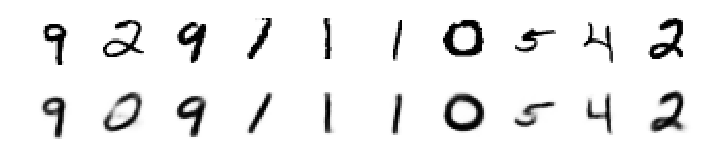

In [1361]:
n_digits = 10

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Encoding Distributions

In [1362]:
# encoder_output contains 3 variables: [ codings, param_0, param_1 ]
encoder_output = encoder.predict(X_test, verbose=True)
print(encoder_output[0].shape)

10000/10000 [==============================] - 0s 50us/step
(10000, 24)


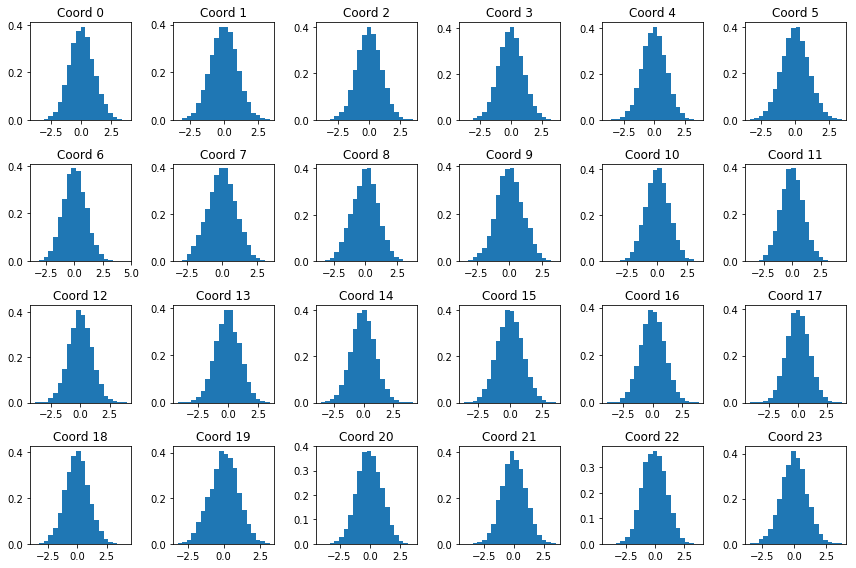

In [1363]:
X_encoded = encoder_output[0]
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 3, 4],
    [ 5, 6, 7, 8, 9]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### Generative

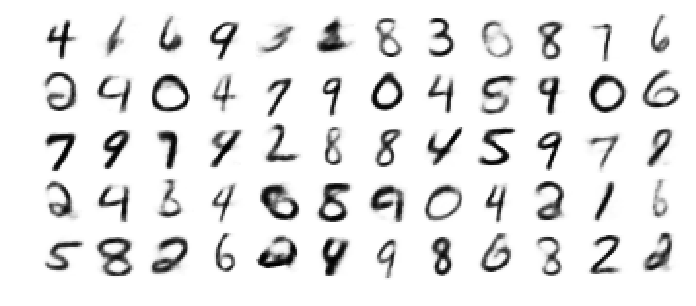

In [1364]:
rows = 5
cols = 12
n_digits = rows * cols

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

## Interpolating digits

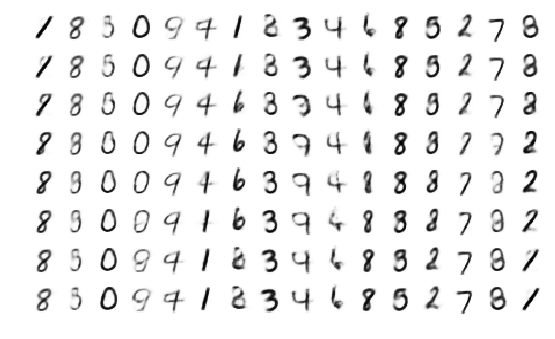

In [1365]:
n_digits = 16
n_iterations = 7

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
codings_target = target_codings = np.roll(codings_in, -1, axis=0)
difference = codings_target - codings_in

images = []

for iteration in range(n_iterations + 1):
    codings_interpolate = codings_in + difference * iteration / n_iterations
    images_out = decoder.predict(codings_interpolate)
    image = combine_images(images_out, rows=1, cols=n_digits)
    images.append(image)


fig = plt.figure(figsize=(0.8*n_digits, 0.8*n_iterations))
for i in range(n_iterations + 1):
    plt.subplot(n_iterations+1, 1, i+1)
    plt.imshow(images[i], cmap="Greys", interpolation='nearest')
    plt.axis("off")

plt.show()

## Conv VAE `k_auto_var3`

In [1415]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

n_codings = 24
model_name = 'k_auto_var3'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

In [1420]:
K.clear_session()
n_inputs = height * width * channels

def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    #return param_0 + param_1 * normal_01
    return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
inputs = Input(shape=(height, width, channels,), name='inputs')

conv1 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(maxpool1)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

flatten = Flatten()(maxpool2)

hidden1 = Dense(units=250, activation='relu')(flatten)
#hidden2 = Dense(units=120, activation='relu')(hidden1)

param_0 = Dense(n_codings, name='param_0')(hidden1)
param_1 = Dense(n_codings, name='param_1')(hidden1)
codings = Lambda(sampling, output_shape=(n_codings,), name='codings')([param_0, param_1])

encoder = Model(inputs, [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 8)    208         inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 8)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 8)    1608        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [1426]:
encoder.layers[-1].output_shape
print(encoder.layers[-6].output_shape)

(None, 7, 7, 8)


In [1434]:
# Build the decoder part of the model
#
n_outputs = n_inputs

latent_inputs = Input(shape=(n_codings,), name='latent_inputs')
hidden3 = Dense(250, activation='relu')(latent_inputs)
hidden4 = Dense(500, activation='relu')(hidden3)

h0 = encoder.layers[-6].output_shape[1]
w0 = encoder.layers[-6].output_shape[2]
feats = 24
hidden5 = Dense(units=h0*w0*feats, activation='relu')(hidden4)

reshape = Reshape(target_shape=(h0, w0, feats,))(hidden5)

up1 = UpSampling2D(size=(2,2))(reshape)
conv3 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(up1)

up2 = UpSampling2D(size=(2,2))(conv3)
conv4 = Conv2D(filters=8, kernel_size=7, strides=1, padding='same', activation='relu')(up2)

conv5 = Conv2D(filters=1, kernel_size=7, strides=1, padding='same')(conv4)
output = Activation('sigmoid', name='output')(conv5)

decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 24)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 250)               6250      
_________________________________________________________________
dense_9 (Dense)              (None, 500)               125500    
_________________________________________________________________
dense_10 (Dense)             (None, 1176)              589176    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 24)          0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 24)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 16)        9616      
__________

In [1435]:
# Stack the two together
#
outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  112114    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         737215    
Total params: 849,329
Trainable params: 849,329
Non-trainable params: 0
_________________________________________________________________


### Loss and Optimizer

In [1436]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 28, 28, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
dist_loss = K.square(param_0) + K.exp(param_1) - 1 - param_1
#dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.15)

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 28, 28, 1) (?, 28, 28, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 24), (None, 24),  112114    
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         737215    
Total params: 849,329
Trainable params: 849,329
Non-trainable params: 0
_________________________________________________________________


### Train / Save / Restore

In [1437]:
epochs = 50
batch_size = 150

history = model.fit(
    X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

Epoch 1/50
60000/60000 [==============================] - 15s 249us/step - loss: 50.2664
Epoch 2/50
60000/60000 [==============================] - 14s 229us/step - loss: 33.9117
Epoch 3/50
60000/60000 [==============================] - 14s 228us/step - loss: 31.3337
Epoch 4/50
60000/60000 [==============================] - 14s 228us/step - loss: 30.2763
Epoch 5/50
60000/60000 [==============================] - 14s 229us/step - loss: 29.6609
Epoch 6/50
60000/60000 [==============================] - 14s 229us/step - loss: 29.2323
Epoch 7/50
60000/60000 [==============================] - 14s 228us/step - loss: 28.9071
Epoch 8/50
60000/60000 [==============================] - 14s 229us/step - loss: 28.6595
Epoch 9/50
60000/60000 [==============================] - 14s 228us/step - loss: 28.3729
Epoch 10/50
60000/60000 [==============================] - 14s 230us/step - loss: 28.2078
Epoch 11/50
60000/60000 [==============================] - 14s 228us/step - loss: 28.0535
Epoch 12/50
60000/6

In [1438]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
model.save(model_file + '.h5')

In [1439]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.compile(loss='binary_crossentropy', optimizer="adam")

### Reconstruction Output

Let's take a look at how well the reconstructions look:

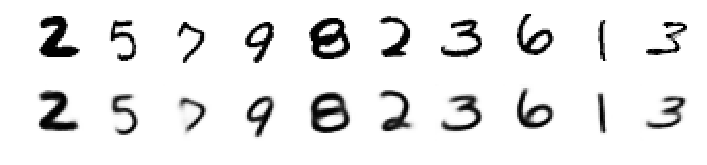

In [1440]:
n_digits = 10

images_in, _ = random_batch(X_test, y_test, batch_size=n_digits)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 2.5))
for digit_index in range(n_digits):
    plt.subplot(2, n_digits, digit_index + 1)
    plot_image(images_in[digit_index].reshape(28,28))
    
    plt.subplot(2, n_digits, n_digits + digit_index + 1)
    plot_image(images_out[digit_index].reshape(28,28))
plt.show()

### Encoding Distributions

In [1441]:
# encoder_output contains 3 variables: [ codings, param_0, param_1 ]
encoder_output = encoder.predict(X_test, verbose=True)
print(encoder_output[0].shape)

10000/10000 [==============================] - 1s 80us/step
(10000, 24)


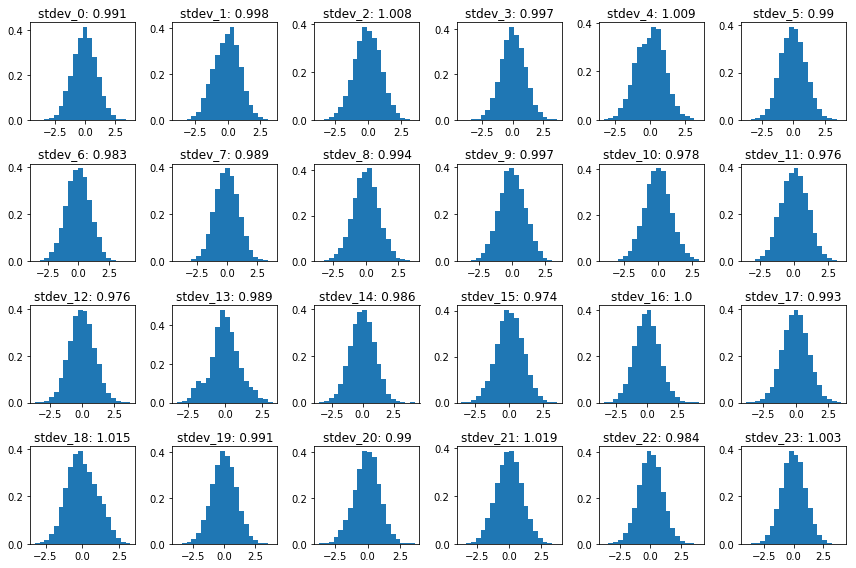

In [1442]:
X_encoded = encoder_output[0]
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 3, 4],
    [ 5, 6, 7, 8, 9]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            stdev = np.round(np.std(X_encoded[:, i]), 3)
            plt.title("stdev_" + str(i) + ": " + str(stdev))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            stdev = np.round(np.std(X_encoded[:, coord_indeces[row, col]]), 3)
            plt.title("stdev_" + str(coord_indeces[row, col]) + ": " + str(stdev))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### Generative

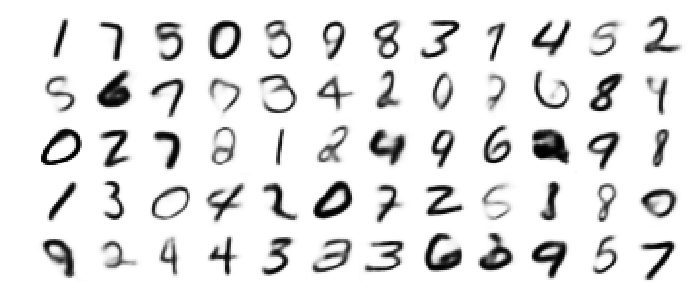

In [1443]:
rows = 5
cols = 12
n_digits = rows * cols

alpha=0.5
#codings_in = noise = np.random.uniform(0.5-alpha, 0.5+alpha, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0.0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols, rows))
plt.imshow(image, cmap="Greys", interpolation='nearest')
plt.axis("off")
plt.show()

## CVAE `k_auto_cvae0`

Feeds conditioning vector only to decoder (concatenate to codings)

Check out http://nnormandin.com/science/2017/07/01/cvae.html

In [5]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate

n_codings = 10
n_attributes = 10 #dimension of the conditioning vector
model_name = 'k_auto_cvae0'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

In [6]:
K.clear_session()
n_inputs = height * width * channels

def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    #return param_0 + param_1 * normal_01
    return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
inputs = Input(shape=(height, width, channels,), name='inputs')
condits = Input(shape=(n_attributes,), name='condits')

conv1 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(pool1)
pool = MaxPooling2D(pool_size=(2, 2))(conv2)

flatten = Flatten()(pool)
#merged = concatenate([flatten, condits], axis=-1, name='merged')

dense = Dense(units=250, activation='relu')(flatten)#(merged)

param_0 = Dense(n_codings, name='param_0')(dense)
param_1 = Dense(n_codings, name='param_1')(dense)
codings0 = Lambda(sampling, output_shape=(n_codings,), name='codings1')([param_0, param_1])

codings = concatenate([codings0, condits], axis=-1, name='codings')

encoder = Model([inputs, condits], [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   416         inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   12832       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [11]:
print(encoder.layers[-1].output_shape)
print(encoder.layers[-2].output_shape)
print(encoder.layers[-8].output_shape)

(None, 20)
(None, 10)
(None, 7, 7, 32)


In [12]:
# Build the decoder part of the model
#
n_outputs = n_inputs
conv_layer_index = -8

latent_inputs = Input(shape=(n_codings + n_attributes,), name='latent_inputs')
#latent_condits = Input(shape=(n_attributes,), name='latent_condits')

#inputs_condits = concatenate([latent_inputs, latent_condits], axis=-1, name='inputs_condits')

dense3 = Dense(120, activation='relu')(latent_inputs)#(inputs_condits)
#dense4 = Dense(250, activation='relu')(dense3)

h0 = encoder.layers[conv_layer_index].output_shape[1]
w0 = encoder.layers[conv_layer_index].output_shape[2]
feats = 32
dense5 = Dense(units=h0*w0*feats, activation='relu')(dense3)

reshape = Reshape(target_shape=(h0, w0, feats,))(dense5)

up1 = UpSampling2D(size=(2,2))(reshape)
conv5 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(up1)

up2 = UpSampling2D(size=(2,2))(conv5)
conv6 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(up2)

#up3 = UpSampling2D(size=(2,2))(conv6)
#conv7 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(up3)

#up4 = UpSampling2D(size=(2,2))(conv7)
#conv8 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(up4)

conv = Conv2D(filters=1, kernel_size=5, strides=1, padding='same')(conv6)
output = Activation('sigmoid', name='output')(conv)

decoder = Model([latent_inputs], output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               2520      
_________________________________________________________________
dense_3 (Dense)              (None, 1568)              189728    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        12816     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 16)        0         
__________

In [13]:
# Stack the two together
#
outputs = decoder(  encoder([inputs, condits])[0]  )
model = Model([inputs, condits], outputs, name='vae')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
condits (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 20), (None,  410518      inputs[0][0]                     
                                                                 condits[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    208473      encoder[1][0]                    
Total para

### Loss and Optimizer

In [14]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 64, 64, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
dist_loss = K.square(param_0) + K.exp(param_1) - 1 - param_1
#dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.10)

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 28, 28, 1) (?, 28, 28, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
condits (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 20), (None,  410518      inputs[0][0]                     
                                                                 condits[0][0]                    
__________________________________________________________________________________________________
decoder (Model) 

### Train / Save / Restore

In [16]:
epochs = 30
batch_size = 150

history = model.fit(
    x=[X_train, X_train_cond], batch_size=batch_size, epochs=epochs, verbose=1
)


# compile and fit
#cvae_hist = cvae.fit(
#    [X_train, y_train], X_train, verbose = 0, batch_size=m, epochs=n_epoch,
#    validation_data = ([X_test, y_test], X_test),
#    callbacks = [EarlyStopping(patience = 5),
#    TQDMNotebookCallback(metric_format="{name}: {value:0.1f}",
#    leave_outer=False)]
#)

Epoch 1/30
60000/60000 [==============================] - 13s 211us/step - loss: 46.5061
Epoch 2/30
60000/60000 [==============================] - 11s 177us/step - loss: 30.1354
Epoch 3/30
60000/60000 [==============================] - 11s 177us/step - loss: 27.8378
Epoch 4/30
60000/60000 [==============================] - 11s 177us/step - loss: 26.7936
Epoch 5/30
60000/60000 [==============================] - 11s 177us/step - loss: 26.2189
Epoch 6/30
60000/60000 [==============================] - 11s 178us/step - loss: 25.7945
Epoch 7/30
60000/60000 [==============================] - 11s 177us/step - loss: 25.5276
Epoch 8/30
60000/60000 [==============================] - 11s 179us/step - loss: 25.2796
Epoch 9/30
60000/60000 [==============================] - 11s 178us/step - loss: 25.0839
Epoch 10/30
60000/60000 [==============================] - 11s 177us/step - loss: 24.9362
Epoch 11/30
60000/60000 [==============================] - 11s 177us/step - loss: 24.7931
Epoch 12/30
60000/6

In [17]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
#model.save(model_file + '.h5')

In [1360]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.compile(loss='binary_crossentropy', optimizer="adam")

### Reconstruction Output

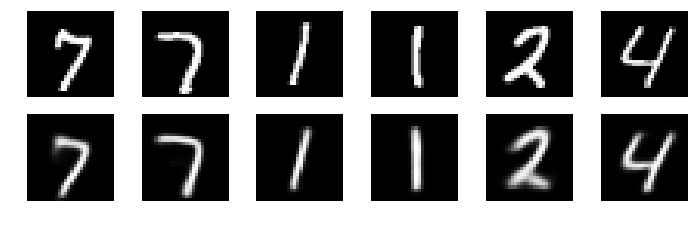

In [19]:
n_images = 6

images_in, cond_in = random_batch(X_train, X_train_cond, batch_size=n_images)
images_out = model.predict([images_in, cond_in])

fig = plt.figure(figsize=(12, 3.5))
for image_index in range(n_images):
    plt.subplot(2, n_images, image_index + 1)
    plot_image(images_in[image_index].reshape(height,width))
    
    plt.subplot(2, n_images, n_images + image_index + 1)
    plot_image(images_out[image_index].reshape(height,width))
plt.show()

### Generative

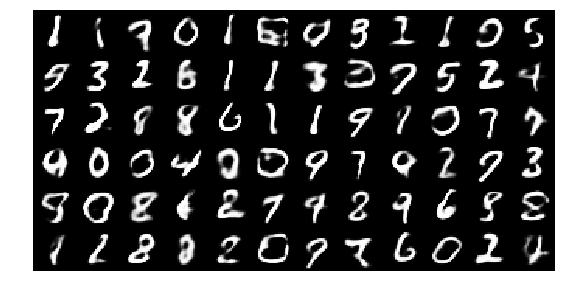

In [36]:
cols = 12
rows = 6
n_images = rows * cols

#codings_in = np.random.uniform(-2, 2, n_images * n_codings).reshape((n_images, n_codings))
codings_in = np.random.normal(
    0, 1.2, n_images * (n_codings+n_attributes)
).reshape((n_images, n_codings+n_attributes))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols*0.8, rows*0.8))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

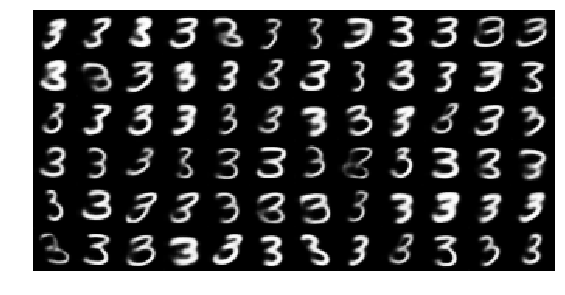

In [65]:
digit = 3

cols = 12
rows = 6
n_images = rows * cols

digit_cond = np.zeros(n_images * n_attributes).reshape((n_images, n_attributes))
digit_cond[:, digit] = 1
#print(digit_cond)

random_features = np.random.normal(
    0, 1.2, n_images * n_codings
).reshape((n_images, n_codings))
#print(random_features)

codings_in = np.c_[random_features, digit_cond]
#print(codings_in)

images_out = decoder.predict(codings_in)
image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols*0.8, rows*0.8))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

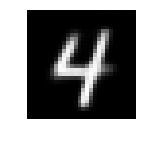

In [64]:
digit = 1

codings_in = np.array([[
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    0,0,0,0,1,0,0,0,0,0
]])

images_out = decoder.predict(codings_in)
image = combine_images(images_out)

fig = plt.figure(figsize=(2, 2))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

## CVAE `k_auto_cvae1`

Conditioning vector plays a role for encoder as well (concatenate before dense)

Check out http://nnormandin.com/science/2017/07/01/cvae.html

In [66]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate

n_codings = 10
n_attributes = 10 #dimension of the conditioning vector
model_name = 'k_auto_cvae1'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'
model_file = 'models/auto/mnist/' + model_name + '-model'

In [67]:
K.clear_session()
n_inputs = height * width * channels

def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    #return param_0 + param_1 * normal_01
    return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
inputs = Input(shape=(height, width, channels,), name='inputs')
condits = Input(shape=(n_attributes,), name='condits')

conv1 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(pool1)
pool = MaxPooling2D(pool_size=(2, 2))(conv2)

flatten = Flatten()(pool)
merged = concatenate([flatten, condits], axis=-1, name='merged')

dense = Dense(units=250, activation='relu')(merged)#(flatten)

param_0 = Dense(n_codings, name='param_0')(dense)
param_1 = Dense(n_codings, name='param_1')(dense)
codings0 = Lambda(sampling, output_shape=(n_codings,), name='codings1')([param_0, param_1])

codings = concatenate([codings0, condits], axis=-1, name='codings')

encoder = Model([inputs, condits], [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   416         inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   12832       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [69]:
print(encoder.layers[-1].output_shape)
print(encoder.layers[-2].output_shape)
print(encoder.layers[-9].output_shape)

(None, 20)
(None, 10)
(None, 7, 7, 32)


In [70]:
# Build the decoder part of the model
#
n_outputs = n_inputs
conv_layer_index = -9

latent_inputs = Input(shape=(n_codings + n_attributes,), name='latent_inputs')
#latent_condits = Input(shape=(n_attributes,), name='latent_condits')

#inputs_condits = concatenate([latent_inputs, latent_condits], axis=-1, name='inputs_condits')

dense3 = Dense(120, activation='relu')(latent_inputs)#(inputs_condits)
#dense4 = Dense(250, activation='relu')(dense3)

h0 = encoder.layers[conv_layer_index].output_shape[1]
w0 = encoder.layers[conv_layer_index].output_shape[2]
feats = 32
dense5 = Dense(units=h0*w0*feats, activation='relu')(dense3)

reshape = Reshape(target_shape=(h0, w0, feats,))(dense5)

up1 = UpSampling2D(size=(2,2))(reshape)
conv5 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(up1)

up2 = UpSampling2D(size=(2,2))(conv5)
conv6 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(up2)

#up3 = UpSampling2D(size=(2,2))(conv6)
#conv7 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(up3)

#up4 = UpSampling2D(size=(2,2))(conv7)
#conv8 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(up4)

conv = Conv2D(filters=1, kernel_size=5, strides=1, padding='same')(conv6)
output = Activation('sigmoid', name='output')(conv)

decoder = Model([latent_inputs], output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               2520      
_________________________________________________________________
dense_3 (Dense)              (None, 1568)              189728    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 32)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        12816     
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 16)        0         
__________

In [71]:
# Stack the two together
#
outputs = decoder(  encoder([inputs, condits])[0]  )
model = Model([inputs, condits], outputs, name='vae')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
condits (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 20), (None,  413018      inputs[0][0]                     
                                                                 condits[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    208473      encoder[1][0]                    
Total para

### Loss and Optimizer

In [72]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 64, 64, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
dist_loss = K.square(param_0) + K.exp(param_1) - 1 - param_1
#dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.10)

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 28, 28, 1) (?, 28, 28, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
condits (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 20), (None,  413018      inputs[0][0]                     
                                                                 condits[0][0]                    
__________________________________________________________________________________________________
decoder (Model) 

### Train / Save / Restore

In [73]:
epochs = 30
batch_size = 150

history = model.fit(
    x=[X_train, X_train_cond], batch_size=batch_size, epochs=epochs, verbose=1
)


# compile and fit
#cvae_hist = cvae.fit(
#    [X_train, y_train], X_train, verbose = 0, batch_size=m, epochs=n_epoch,
#    validation_data = ([X_test, y_test], X_test),
#    callbacks = [EarlyStopping(patience = 5),
#    TQDMNotebookCallback(metric_format="{name}: {value:0.1f}",
#    leave_outer=False)]
#)

Epoch 1/30
60000/60000 [==============================] - 12s 198us/step - loss: 43.4477
Epoch 2/30
60000/60000 [==============================] - 11s 180us/step - loss: 28.8623
Epoch 3/30
60000/60000 [==============================] - 11s 184us/step - loss: 26.6578
Epoch 4/30
60000/60000 [==============================] - 11s 183us/step - loss: 25.7838
Epoch 5/30
60000/60000 [==============================] - 11s 182us/step - loss: 25.2338
Epoch 6/30
60000/60000 [==============================] - 11s 179us/step - loss: 24.8521
Epoch 7/30
60000/60000 [==============================] - 11s 179us/step - loss: 24.5418
Epoch 8/30
60000/60000 [==============================] - 11s 181us/step - loss: 24.3392
Epoch 9/30
60000/60000 [==============================] - 11s 178us/step - loss: 24.1711
Epoch 10/30
60000/60000 [==============================] - 11s 178us/step - loss: 23.9828
Epoch 11/30
60000/60000 [==============================] - 11s 178us/step - loss: 23.8614
Epoch 12/30
60000/6

In [74]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
#model.save(model_file + '.h5')

In [1360]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.compile(loss='binary_crossentropy', optimizer="adam")

### Reconstruction Output

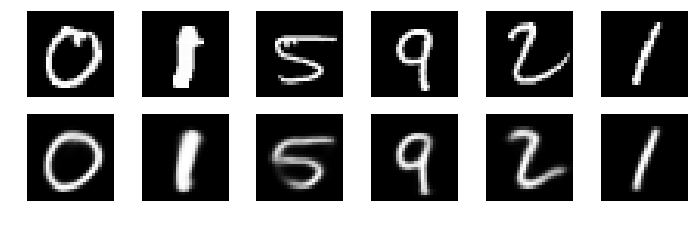

In [75]:
n_images = 6

images_in, cond_in = random_batch(X_train, X_train_cond, batch_size=n_images)
images_out = model.predict([images_in, cond_in])

fig = plt.figure(figsize=(12, 3.5))
for image_index in range(n_images):
    plt.subplot(2, n_images, image_index + 1)
    plot_image(images_in[image_index].reshape(height,width))
    
    plt.subplot(2, n_images, n_images + image_index + 1)
    plot_image(images_out[image_index].reshape(height,width))
plt.show()

### Generative

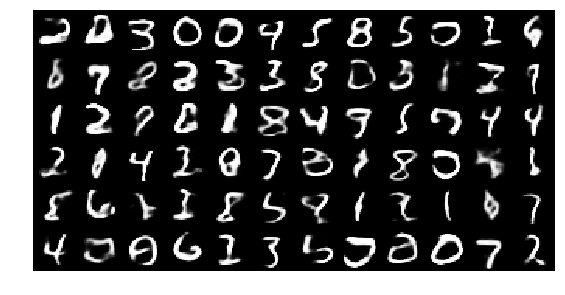

In [77]:
cols = 12
rows = 6
n_images = rows * cols

#codings_in = np.random.uniform(-2, 2, n_images * n_codings).reshape((n_images, n_codings))
codings_in = np.random.normal(
    0, 1.2, n_images * (n_codings+n_attributes)
).reshape((n_images, n_codings+n_attributes))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols*0.8, rows*0.8))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

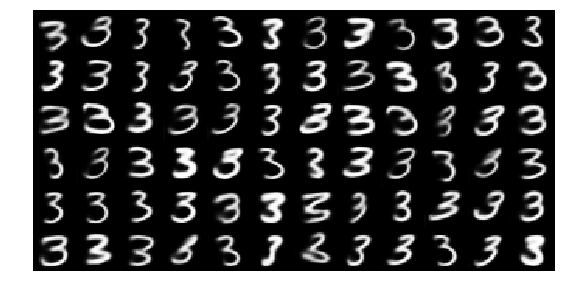

In [78]:
digit = 3

cols = 12
rows = 6
n_images = rows * cols

digit_cond = np.zeros(n_images * n_attributes).reshape((n_images, n_attributes))
digit_cond[:, digit] = 1
#print(digit_cond)

random_features = np.random.normal(
    0, 1.2, n_images * n_codings
).reshape((n_images, n_codings))
#print(random_features)

codings_in = np.c_[random_features, digit_cond]
#print(codings_in)

images_out = decoder.predict(codings_in)
image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols*0.8, rows*0.8))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

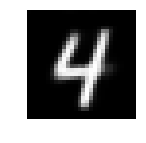

In [79]:
digit = 1

codings_in = np.array([[
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    0,0,0,0,1,0,0,0,0,0
]])

images_out = decoder.predict(codings_in)
image = combine_images(images_out)

fig = plt.figure(figsize=(2, 2))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

## PCA visualization

### 2D

In [1471]:
from keras.models import load_model

model_name = 'k_auto_var3'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'

encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

n_codings = encoder.layers[-1].output_shape[1]
print(n_codings)

24


In [1472]:
n_points = 3000
X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch)[0]

In [1473]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X2d.shape)

Compressed (3000, 24) into (3000, 2)


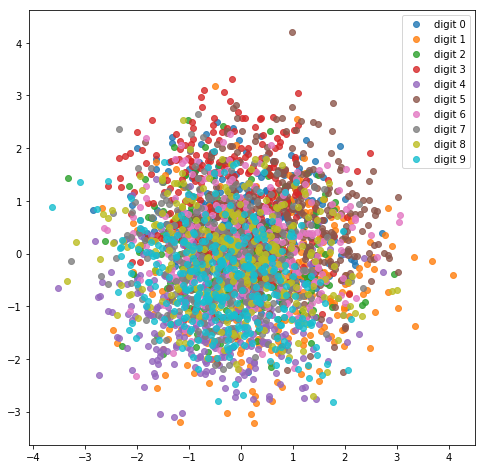

In [1474]:
index_list = []
for i in range(10):
    index_list.append(y_batch == i)

plt.figure(figsize=(8,8))
for i in range(10):
    plt.scatter(
        X2d[:, 0][index_list[i]], 
        X2d[:, 1][index_list[i]], 
        cmap=y_batch[index_list[i]], 
        label=str('digit ' + str(i)), marker='o', alpha=0.8
    )
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')
plt.legend()
plt.show()

Color bar visualization looks better than legend.

Possible `colormap` values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

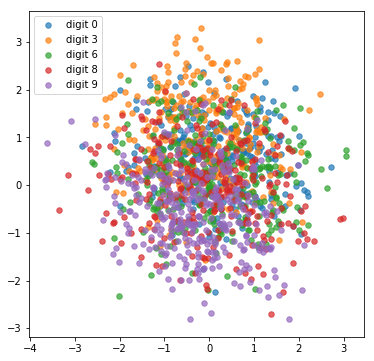

In [1475]:
digit_list = [0, 3, 6, 8, 9]

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)

plt.figure(figsize=(6,6))
for i in range(len(index_list)):
    plt.scatter(X2d[index_list[i], 0], X2d[index_list[i], 1], 
        s=30, cmap=y_batch[index_list[i]], marker='o', alpha=0.7,
        label=str('digit ' + str(digit_list[i])), 
    )
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')
plt.legend()
plt.show()

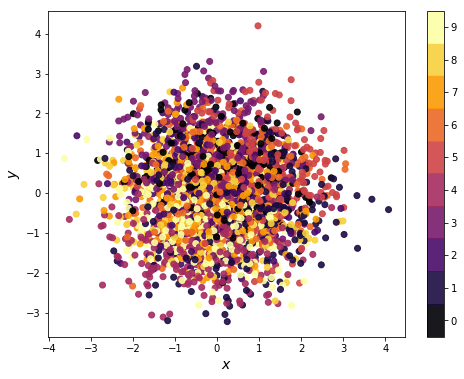

In [1476]:
fig = plt.figure(figsize=(8,6))

colors = y_batch
colormap = plt.get_cmap('inferno', 10)

p = plt.scatter(X2d[:, 0], X2d[:, 1],
        c=colors, cmap=colormap, marker='o', alpha=0.9
)

plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
plt.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5 * (9.0/10.0), 1.5*.... etc
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

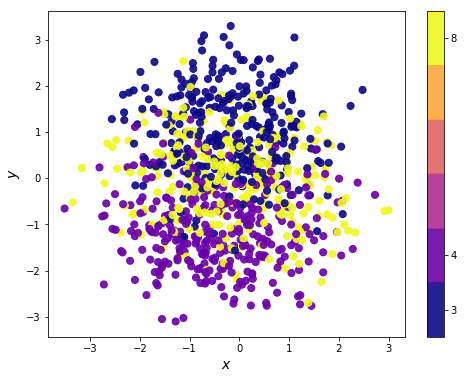

In [1483]:
digit_list = [3, 4, 8]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(8,6))

colors = y_batch[indeces]
colormap = plt.get_cmap('plasma', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=50, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

`KernelPCA` gives us different kernels to work with. Here are some common kernels:
* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a}^T - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

Options:
* `n_components` : int, default=None
* `kernel=` : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
* `gamma` : float, default=1/n_features
* `degree` : int, default=3 (for poly kernels)
* `coef0` : float, default=1 (independent term in poly and sigmoid kernels, ignored by other kernels)


In [1484]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.05, degree=2)
X2d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X2d.shape)

Compressed (3000, 24) into (3000, 2)


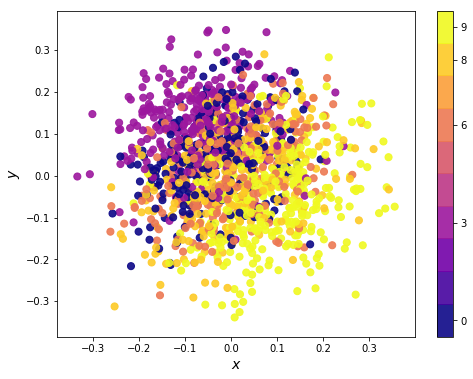

In [1485]:
digit_list = [0, 3, 6, 8, 9]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(8,6))

colors = y_batch[indeces]
colormap = plt.get_cmap('plasma', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=50, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

### 3D

In [1461]:
from keras.models import load_model

#model_name = 'k_auto1'
model_name = 'k_auto_var3'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'

encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

n_codings = encoder.layers[-1].output_shape[1]
print(n_codings)

24


In [1464]:
n_points = 3000
X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch)[0]

In [1465]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X3d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X3d.shape)

Compressed (3000, 24) into (3000, 3)


Possible `colormap` values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

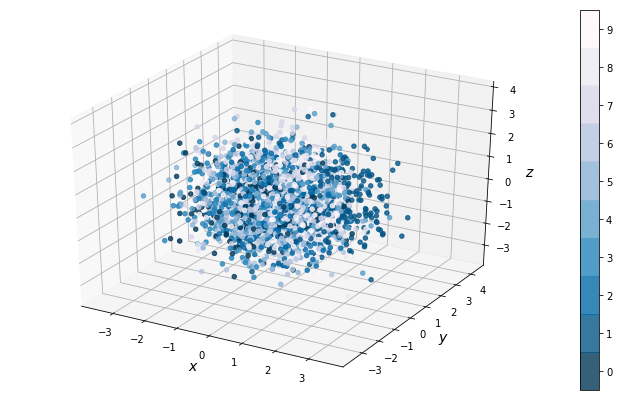

In [1466]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,7))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch# / 9.0
colormap = plt.get_cmap('PuBu_r', 10)

p = ax3d.scatter3D(
        X3d[:, 0], X3d[:, 1], X3d[:, 2],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)

ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5 * (9.0/10.0), 1.5*.... etc
tick_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

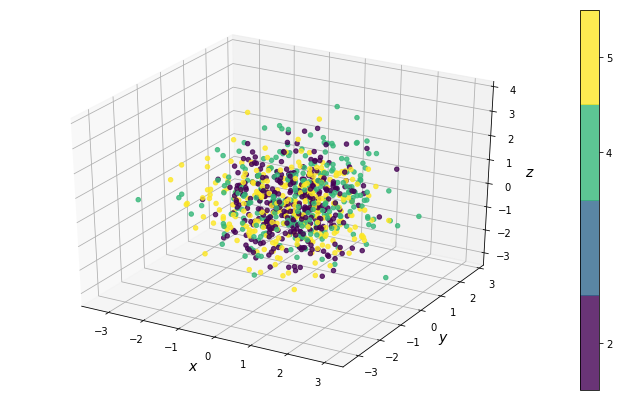

In [1467]:
from mpl_toolkits.mplot3d import Axes3D

digit_list = [2, 4, 5]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

fig = plt.figure(figsize=(12,7))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch[indeces]
colormap = plt.get_cmap('viridis', n_bins)

p = ax3d.scatter3D(X3d[:, 0][indeces], X3d[:, 1][indeces], X3d[:, 2][indeces],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)
ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

`KernelPCA` gives us different kernels to work with. Here are some common kernels:
* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a}^T - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

Options:
* `n_components` : int, default=None
* `kernel=` : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
* `gamma` : float, default=1/n_features
* `degree` : int, default=3 (for poly kernels)
* `coef0` : float, default=1 (independent term in poly and sigmoid kernels, ignored by other kernels)


In [1468]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=3, kernel='cosine', gamma=0.15, degree=-1)
X3d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X3d.shape)

Compressed (3000, 24) into (3000, 3)


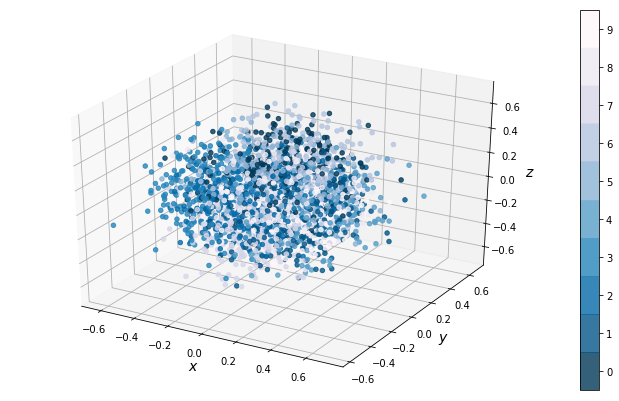

In [1469]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,7))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch# / 9.0
colormap = plt.get_cmap('PuBu_r', 10)

p = ax3d.scatter3D(X3d[:, 0], X3d[:, 1], X3d[:, 2],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)

ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5 * (9.0/10.0), 1.5*.... etc
tick_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

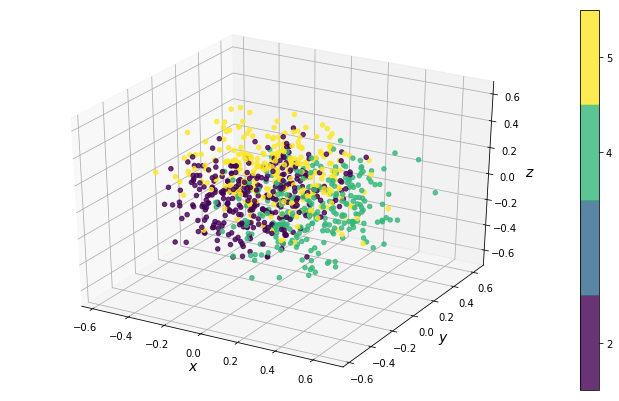

In [1470]:
from mpl_toolkits.mplot3d import Axes3D

digit_list = [2, 4, 5]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

fig = plt.figure(figsize=(12,7))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch[indeces]
colormap = plt.get_cmap('viridis', n_bins)

p = ax3d.scatter3D(X3d[:, 0][indeces], X3d[:, 1][indeces], X3d[:, 2][indeces],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)
ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

# Celeb-a (64x64x1)

* <b>5_o_Clock_Shadow</b>
* Arched_Eyebrows 
* <b>Attractive</b>
* Bags_Under_Eyes 
* Bald 
* Bangs 
* Big_Lips 
* Big_Nose 
* Black_Hair 
* Blond_Hair 
* <b>Blurry</b>
* Brown_Hair 
* Bushy_Eyebrows 
* Chubby 
* Double_Chin 
* <b>Eyeglasses</b>
* Goatee 
* Gray_Hair 
* Heavy_Makeup 
* High_Cheekbones 
* <b>Male</b>
* Mouth_Slightly_Open 
* Mustache 
* Narrow_Eyes 
* <b>No_Beard</b>
* Oval_Face 
* Pale_Skin 
* Pointy_Nose 
* Receding_Hairline 
* Rosy_Cheeks 
* Sideburns 
* <b>Smiling</b>
* Straight_Hair 
* Wavy_Hair 
* Wearing_Earrings 
* Wearing_Hat 
* Wearing_Lipstick 
* Wearing_Necklace 
* Wearing_Necktie 
* <b>Young</b>

## Data

In [1]:
# This needs to be edited by hand. Features we are interested in are:
# #### Basic Attributes ####
# attr.Male
# attr.Attractive
# attr.Smiling
# attr.Young
# attr.Mouth_Slightly_Open
#
# #### Facial Features ####
# 
# attr.Big_Lips
# attr.Big_Nose
# attr.High_Cheekbones
#
# attr.Heavy_Makeup OR attr.Wearing_Lipstick
# attr.Straight_Hair
# attr.Wavy_Hair
# attr.Black_Hair OR attr.Brown_Hair
# attr.Blond_Hair
# attr.No_Beard
#
def image_filter(i, attr):
    if attr.Blurry[i] == 1:# we only want high-quality non-blurry photos
        return False
    if attr.Male[i] == 1:
        return False
    if attr.Attractive[i] == -1:
        return False
    if attr.Eyeglasses[i] == 1:
        return False
    if attr.Young[i] == -1:
        return False
    return True    
    
#############################################################
#
height = 64
width = 64
channels = 1
n_attributes = 3

subfolder = str(height) + "x" + str(width) + "-" + str(channels)
ROOT_PATH = os.path.join("D:/datasets/celeb-aligned/" + subfolder)
#print(ROOT_PATH)

image_paths = []
attr = pd.read_csv("D:/datasets/celeb-aligned/list_attr_celeba.csv")

for i in range(attr.image_id.shape[0]):
    print("\rFiltering images... {:}% (found {:})"
          .format(round(100*i / attr.image_id.shape[0], 1), len(image_paths)), end="")
    sys.stdout.flush()
    filename = attr.image_id[i]
    if image_filter(i, attr):
        image_path = os.path.join(ROOT_PATH, filename)
        image_paths.append(image_path)
        
#np.random.shuffle(image_paths)

NameError: name 'os' is not defined

In [5]:
# Load the data to RAM (if it fits!), then normalize it
#
dataset_size = 101144 #should be at least 1000

def conditioning_vector(i, attr):
    attr_vector = np.zeros(3) #we keep track of 9 features (see above)
    attr_vector[0] = attr.Male[i]
    attr_vector[1] = attr.Smiling[i]
    attr_vector[2] = attr.Young[i]
    #if attr.Mouth_Slightly_Open[i] == 1:
    #    attr_vector[4] = 1
    #if attr.Heavy_Makeup[i] == 1 or attr.Wearing_Lipstick[i] == 1:
    #    attr_vector[5] = 1
    #if attr.Black_Hair[i] == 1 or attr.Brown_Hair[i] == 1:
    #    attr_vector[5] = 1
    #if attr.Blond_Hair[i] == 1:
    #    attr_vector[6] = 1
    #if attr.No_Beard[i] == -1: #complement of having no beard
    #    attr_vector[7] = 1
    return attr_vector;

m = min(len(image_paths), dataset_size)

X_train = np.zeros([m, height, width, channels])
X_cond = np.zeros([m, n_attributes])

for i in range(m):
    if i % (m // 1000) == 0:
        print("\rLoading data to RAM... {:}% ".format(round(100*i / m, 1)), end="")
        sys.stdout.flush()
    image_path = image_paths[i]
    image = mpimg.imread(image_path)#[:, :, :]
    X_cond[i] = conditioning_vector(i, attr)
    if channels == 1:
        X_train[i] = image.astype("float32").reshape([height, width, channels]) / 255.0
    else:
        X_train[i] = image.astype("float32") / 255.0 #.reshape([height, width, channels])
print("done:", X_train.shape, X_cond.shape)

Loading data to RAM... 100.0% done: (101144, 64, 64, 1) (101144, 3)


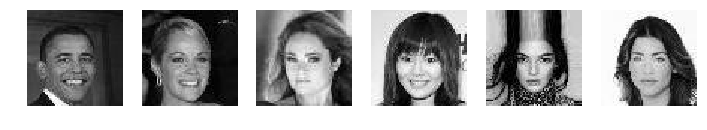

In [6]:
n_examples = 6

X_batch = random_batch_1d(X_train, n_examples)

plt.figure(figsize=(12,4))
for i in range(n_examples):
    image = X_batch[i]
    #print(image.shape)
    plt.subplot(1, n_examples, i + 1)
    plt.axis("off")
    if channels == 1:
        plt.imshow(image.reshape([height,width]), cmap="gray", interpolation="nearest")
    else:
        plt.imshow(image)
plt.show()

In [7]:
#X_train = X_train * 2 - 1
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], channels))

print(X_train.shape, np.min(X_train), np.max(X_train))

(101144, 64, 64, 1) 0.0 1.0


## VAE 'k_auto_var0'

In [142]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

n_codings = 60
model_name = 'k_auto_var0'

encoder_file = 'models/auto/celeb64-1/' + model_name + '-enc'
decoder_file = 'models/auto/celeb64-1/' + model_name + '-dec'
model_file = 'models/auto/celeb-1/' + model_name + '-model'

In [143]:
K.clear_session()
n_inputs = height * width * channels

def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    #return param_0 + param_1 * normal_01
    return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
inputs = Input(shape=(height, width, channels,), name='inputs')

conv1 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(pool4)

hidden1 = Dense(units=250, activation='relu')(flatten)
#hidden2 = Dense(units=120, activation='relu')(hidden1)

param_0 = Dense(n_codings, name='param_0')(hidden1)
param_1 = Dense(n_codings, name='param_1')(hidden1)
codings = Lambda(sampling, output_shape=(n_codings,), name='codings')([param_0, param_1])

encoder = Model(inputs, [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 8)    208         inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 8)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 16)   3216        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [144]:
encoder.layers[-1].output_shape
print(encoder.layers[-6].output_shape)

(None, 4, 4, 64)


In [145]:
# Build the decoder part of the model
#
n_outputs = n_inputs

latent_inputs = Input(shape=(n_codings,), name='latent_inputs')
hidden3 = Dense(250, activation='relu')(latent_inputs)
hidden4 = Dense(450, activation='relu')(hidden3)

h0 = encoder.layers[-6].output_shape[1]
w0 = encoder.layers[-6].output_shape[2]
feats = 64
hidden5 = Dense(units=h0*w0*feats, activation='relu')(hidden4)

reshape = Reshape(target_shape=(h0, w0, feats,))(hidden5)

up1 = UpSampling2D(size=(2,2))(reshape)
conv5 = Conv2D(filters=32, kernel_size=7, strides=1, padding='same', activation='relu')(up1)

up2 = UpSampling2D(size=(2,2))(conv5)
conv6 = Conv2D(filters=16, kernel_size=6, strides=1, padding='same', activation='relu')(up2)

up3 = UpSampling2D(size=(2,2))(conv6)
conv7 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(up3)

up4 = UpSampling2D(size=(2,2))(conv7)
conv8 = Conv2D(filters=4, kernel_size=5, strides=1, padding='same', activation='relu')(up4)

conv = Conv2D(filters=1, kernel_size=5, strides=1, padding='same')(conv8)
output = Activation('sigmoid', name='output')(conv)

decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               15250     
_________________________________________________________________
dense_3 (Dense)              (None, 450)               112950    
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              461824    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          100384    
__________

In [146]:
# Stack the two together
#
outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 64, 64, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 60), (None, 60),  353890    
_________________________________________________________________
decoder (Model)              (None, 64, 64, 1)         712969    
Total params: 1,066,859
Trainable params: 1,066,859
Non-trainable params: 0
_________________________________________________________________


### Loss and Optimizer

In [149]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 64, 64, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
dist_loss = K.square(param_0) + K.exp(param_1) - 1 - param_1
#dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.15)

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 64, 64, 1) (?, 64, 64, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 64, 64, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 60), (None, 60),  353890    
_________________________________________________________________
decoder (Model)              (None, 64, 64, 1)         712969    
Total params: 1,066,859
Trainable params: 1,066,859
Non-trainable params: 0
_________________________________________________________________


### Train / Save / Restore

In [151]:
epochs = 100
batch_size = 150

history = model.fit(
    X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

Epoch 1/100
97200/97200 [==============================] - 71s 725us/step - loss: 69.9450
Epoch 2/100
97200/97200 [==============================] - 70s 723us/step - loss: 67.1007
Epoch 3/100
97200/97200 [==============================] - 70s 724us/step - loss: 64.2803
Epoch 4/100
16350/97200 [====>.........................] - ETA: 58s - loss: 62.0757

KeyboardInterrupt: 

In [152]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
#model.save(model_file + '.h5')

In [148]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.compile(loss='binary_crossentropy', optimizer="adam")

### Reconstruction Output

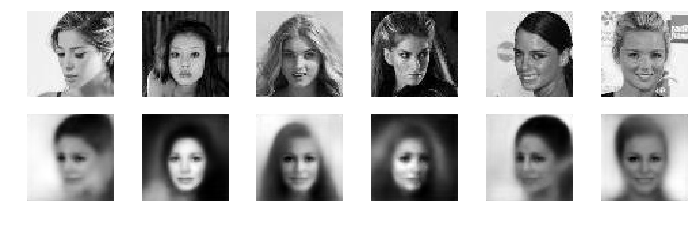

In [153]:
n_images = 6

images_in = random_batch_1d(X_train, batch_size=n_images)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 3.5))
for image_index in range(n_images):
    plt.subplot(2, n_images, image_index + 1)
    plot_image(images_in[image_index].reshape(64,64))
    
    plt.subplot(2, n_images, n_images + image_index + 1)
    plot_image(images_out[image_index].reshape(64,64))
plt.show()

### Encoding Distributions

In [38]:
# encoder_output contains 3 variables: [ codings, param_0, param_1 ]
encoder_output = encoder.predict(X_train, verbose=True)
print(encoder_output[0].shape)

10000/10000 [==============================] - 2s 159us/step
(10000, 60)


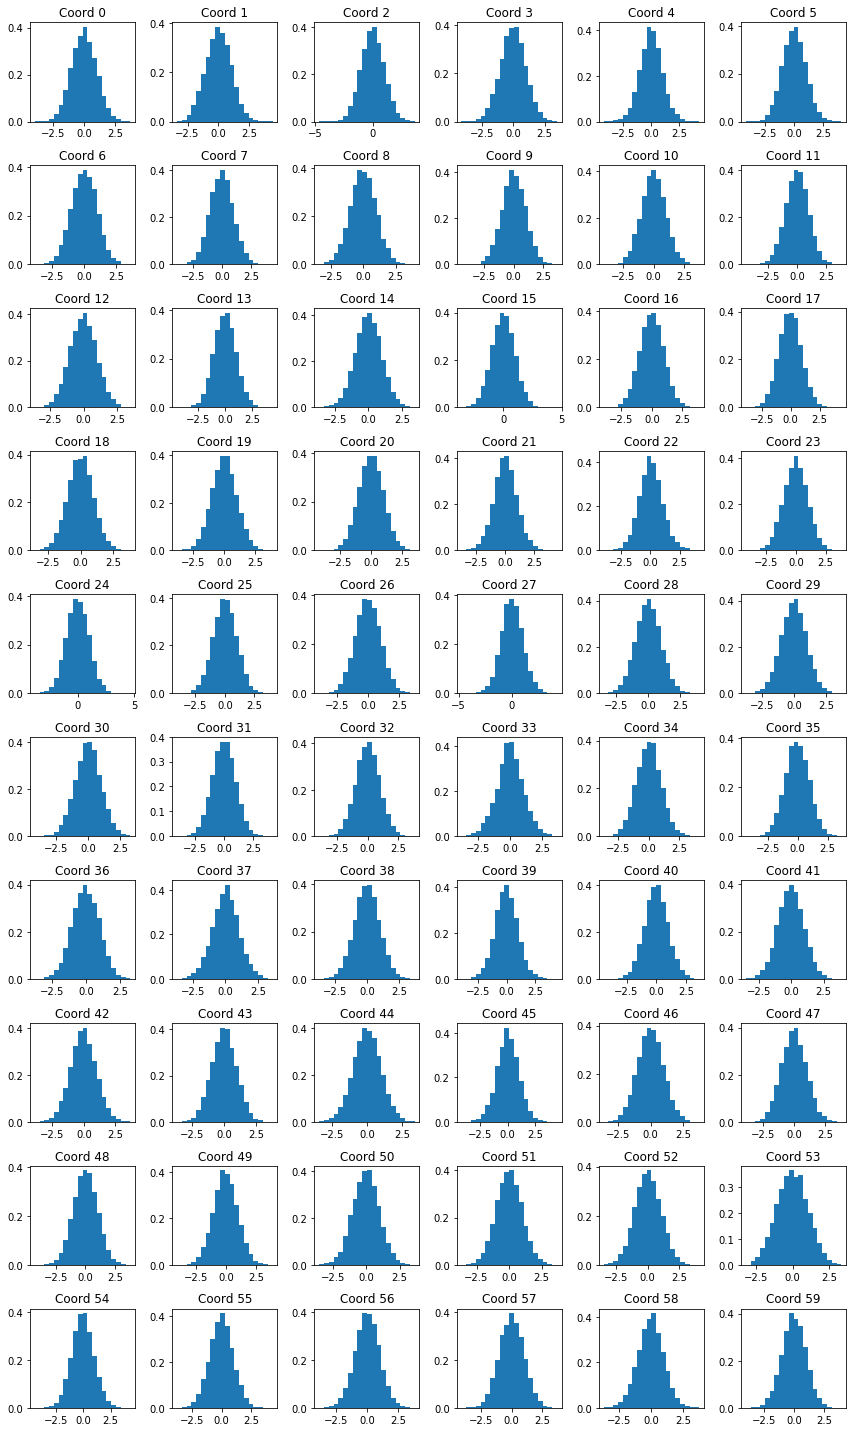

In [39]:
X_encoded = encoder_output[0]
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 3, 4],
    [ 5, 6, 7, 8, 9]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### Generative

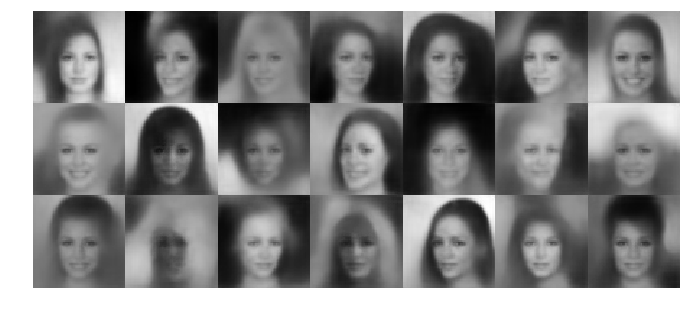

In [155]:
cols = 7
rows = 3
n_faces = rows * cols

#codings_in = noise = np.random.uniform(-2, 2, n_faces * n_codings).reshape((n_faces, n_codings))
codings_in = noise = np.random.normal(0, 1.2, n_faces * n_codings).reshape((n_faces, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols*1.7, rows*1.7))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

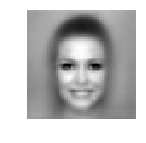

In [160]:
codings_in = np.array([[
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0
]])

images_out = decoder.predict(codings_in)
image = combine_images(images_out)

fig = plt.figure(figsize=(2, 2))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

### Interpolating faces

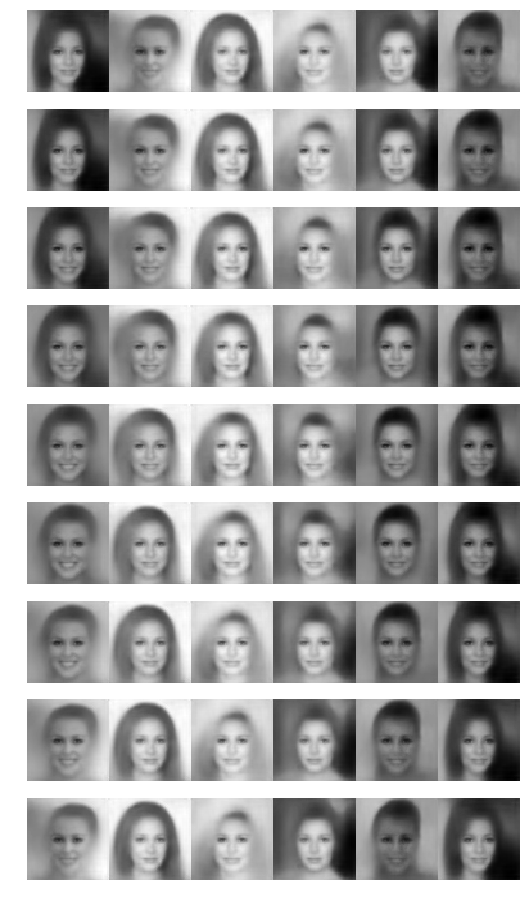

In [161]:
n_digits = 6
n_iterations = 8

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
codings_target = target_codings = np.roll(codings_in, -1, axis=0)
difference = codings_target - codings_in

images = []

for iteration in range(n_iterations + 1):
    codings_interpolate = codings_in + difference * iteration / n_iterations
    images_out = decoder.predict(codings_interpolate)
    image = combine_images(images_out, rows=1, cols=n_digits)
    images.append(image)


fig = plt.figure(figsize=(2*n_digits, 2*n_iterations))
for i in range(n_iterations + 1):
    plt.subplot(n_iterations+1, 1, i+1)
    plt.imshow(images[i], cmap="gray", interpolation='nearest')
    plt.axis("off")

plt.show()

## VAE 'k_auto_var1'

In [162]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

n_codings = 30
model_name = 'k_auto_var1'

encoder_file = 'models/auto/celeb64-1/' + model_name + '-enc'
decoder_file = 'models/auto/celeb64-1/' + model_name + '-dec'
model_file = 'models/auto/celeb-1/' + model_name + '-model'

In [163]:
K.clear_session()
n_inputs = height * width * channels

def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    #return param_0 + param_1 * normal_01
    return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
inputs = Input(shape=(height, width, channels,), name='inputs')

conv1 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(filters=42, kernel_size=5, strides=1, padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(pool4)

dense1 = Dense(units=500, activation='relu')(flatten)
dense = Dense(units=120, activation='relu')(dense1)

param_0 = Dense(n_codings, name='param_0')(dense)
param_1 = Dense(n_codings, name='param_1')(dense)
codings = Lambda(sampling, output_shape=(n_codings,), name='codings')([param_0, param_1])

encoder = Model(inputs, [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   832         inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 42)   33642       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [164]:
encoder.layers[-1].output_shape
print(encoder.layers[-7].output_shape)

(None, 4, 4, 128)


In [165]:
# Build the decoder part of the model
#
n_outputs = n_inputs

latent_inputs = Input(shape=(n_codings,), name='latent_inputs')
dense3 = Dense(250, activation='relu')(latent_inputs)
dense4 = Dense(500, activation='relu')(dense3)

h0 = encoder.layers[-7].output_shape[1]
w0 = encoder.layers[-7].output_shape[2]
feats = 256
dense5 = Dense(units=h0*w0*feats, activation='relu')(dense4)

reshape = Reshape(target_shape=(h0, w0, feats,))(dense5)

up1 = UpSampling2D(size=(2,2))(reshape)
conv5 = Conv2D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu')(up1)

up2 = UpSampling2D(size=(2,2))(conv5)
conv6 = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(up2)

up3 = UpSampling2D(size=(2,2))(conv6)
conv7 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(up3)

up4 = UpSampling2D(size=(2,2))(conv7)
conv8 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(up4)

conv = Conv2D(filters=1, kernel_size=5, strides=1, padding='same')(conv8)
output = Activation('sigmoid', name='output')(conv)

decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               7750      
_________________________________________________________________
dense_4 (Dense)              (None, 500)               125500    
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              2052096   
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         819328    
__________

In [166]:
# Stack the two together
#
outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 64, 64, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 30), (None, 30),  1398546   
_________________________________________________________________
decoder (Model)              (None, 64, 64, 1)         3273987   
Total params: 4,672,533
Trainable params: 4,672,533
Non-trainable params: 0
_________________________________________________________________


### Loss and Optimizer

In [179]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 64, 64, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
dist_loss = K.square(param_0) + K.exp(param_1) - 1 - param_1
#dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.15)

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 64, 64, 1) (?, 64, 64, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 64, 64, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 30), (None, 30),  1398546   
_________________________________________________________________
decoder (Model)              (None, 64, 64, 1)         3273987   
Total params: 4,672,533
Trainable params: 4,672,533
Non-trainable params: 0
_________________________________________________________________


### Train / Save / Restore

In [207]:
epochs = 20
batch_size = 150

history = model.fit(
    X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

Epoch 1/20
97200/97200 [==============================] - 191s 2ms/step - loss: 442.3189
Epoch 2/20
97200/97200 [==============================] - 189s 2ms/step - loss: 442.2645
Epoch 3/20
97200/97200 [==============================] - 189s 2ms/step - loss: 442.5220
Epoch 4/20
97200/97200 [==============================] - 189s 2ms/step - loss: 441.9417
Epoch 5/20
97200/97200 [==============================] - 189s 2ms/step - loss: 441.8073
Epoch 6/20
97200/97200 [==============================] - 189s 2ms/step - loss: 441.9364
Epoch 7/20
97200/97200 [==============================] - 189s 2ms/step - loss: 441.3878
Epoch 8/20
97200/97200 [==============================] - 189s 2ms/step - loss: 441.6453
Epoch 9/20
97200/97200 [==============================] - 189s 2ms/step - loss: 441.3041
Epoch 10/20
97200/97200 [==============================] - 189s 2ms/step - loss: 441.2747
Epoch 11/20
97200/97200 [==============================] - 189s 2ms/step - loss: 440.8205
Epoch 12/20
97200/9

In [208]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
#model.save(model_file + '.h5')

In [1360]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.compile(loss='binary_crossentropy', optimizer="adam")

### Reconstruction Output

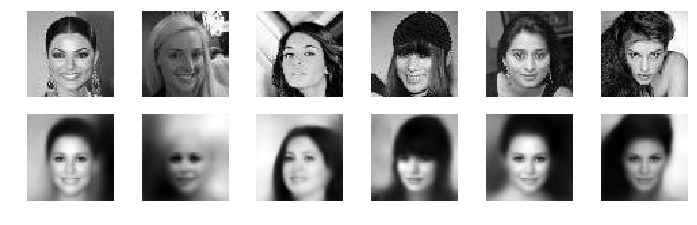

In [209]:
n_images = 6

images_in = random_batch_1d(X_train, batch_size=n_images)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 3.5))
for image_index in range(n_images):
    plt.subplot(2, n_images, image_index + 1)
    plot_image(images_in[image_index].reshape(64,64))
    
    plt.subplot(2, n_images, n_images + image_index + 1)
    plot_image(images_out[image_index].reshape(64,64))
plt.show()

### Encoding Distributions

In [183]:
# encoder_output contains 3 variables: [ codings, param_0, param_1 ]
encoder_output = encoder.predict(X_train, verbose=True)
print(encoder_output[0].shape)

97200/97200 [==============================] - 25s 256us/step
(97200, 30)


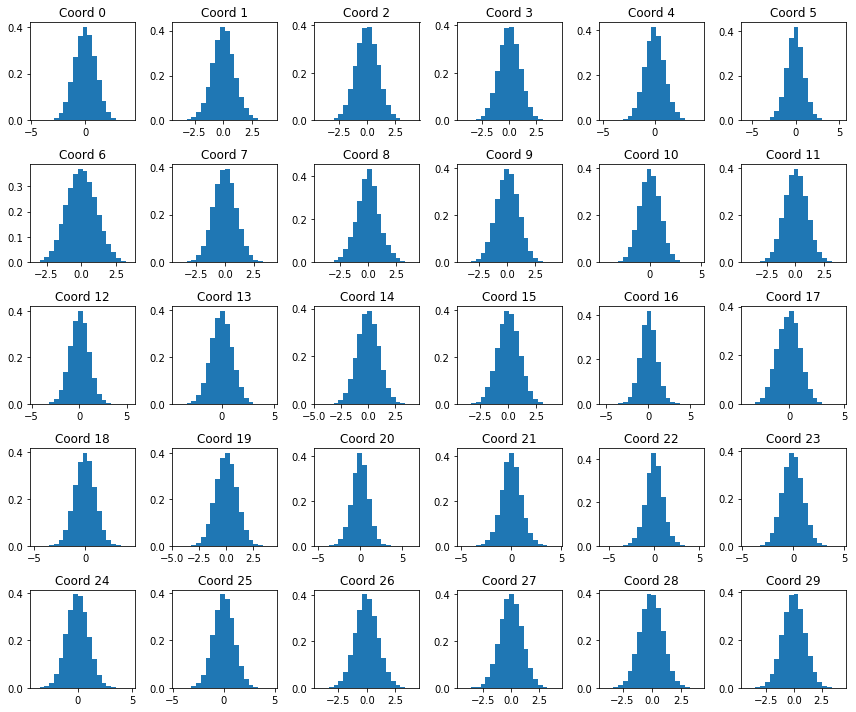

In [184]:
X_encoded = encoder_output[0]
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 3, 4],
    [ 5, 6, 7, 8, 9]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### Generative

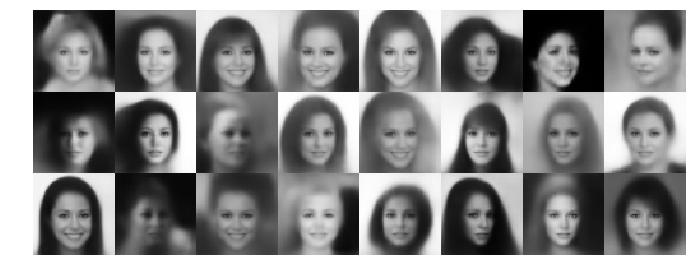

In [196]:
cols = 8
rows = 3
n_faces = rows * cols

#codings_in = noise = np.random.uniform(-2, 2, n_faces * n_codings).reshape((n_faces, n_codings))
codings_in = noise = np.random.normal(0, 1.2, n_faces * n_codings).reshape((n_faces, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols*1.5, rows*1.5))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

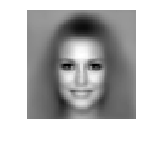

In [200]:
codings_in = np.array([[
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0
]])

images_out = decoder.predict(codings_in)
image = combine_images(images_out)

fig = plt.figure(figsize=(2, 2))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

### Interpolating Faces

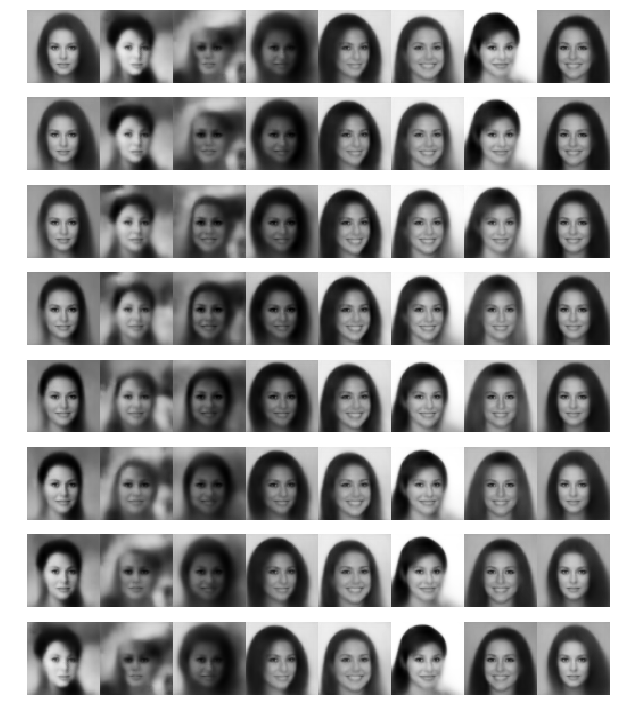

In [201]:
n_digits = 8
n_iterations = 7

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
codings_target = target_codings = np.roll(codings_in, -1, axis=0)
difference = codings_target - codings_in

images = []

for iteration in range(n_iterations + 1):
    codings_interpolate = codings_in + difference * iteration / n_iterations
    images_out = decoder.predict(codings_interpolate)
    image = combine_images(images_out, rows=1, cols=n_digits)
    images.append(image)


fig = plt.figure(figsize=(1.8*n_digits, 1.8*n_iterations))
for i in range(n_iterations + 1):
    plt.subplot(n_iterations+1, 1, i+1)
    plt.imshow(images[i], cmap="gray", interpolation='nearest')
    plt.axis("off")

plt.show()

In [115]:
print()## VAE 'k_auto_var0'

from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

n_codings = 60
model_name = 'k_auto_var0'

encoder_file = 'models/auto/celeb64-1/' + model_name + '-enc'
decoder_file = 'models/auto/celeb64-1/' + model_name + '-dec'
model_file = 'models/auto/celeb-1/' + model_name + '-model'

K.clear_session()
n_inputs = height * width * channels

def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    #return param_0 + param_1 * normal_01
    return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
inputs = Input(shape=(height, width, channels,), name='inputs')

conv1 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(pool4)

hidden1 = Dense(units=250, activation='relu')(flatten)
#hidden2 = Dense(units=120, activation='relu')(hidden1)

param_0 = Dense(n_codings, name='param_0')(hidden1)
param_1 = Dense(n_codings, name='param_1')(hidden1)
codings = Lambda(sampling, output_shape=(n_codings,), name='codings')([param_0, param_1])

encoder = Model(inputs, [codings, param_0, param_1], name='encoder')
encoder.summary()

encoder.layers[-1].output_shape
print(encoder.layers[-6].output_shape)

# Build the decoder part of the model
#
n_outputs = n_inputs

latent_inputs = Input(shape=(n_codings,), name='latent_inputs')
hidden3 = Dense(250, activation='relu')(latent_inputs)
hidden4 = Dense(450, activation='relu')(hidden3)

h0 = encoder.layers[-6].output_shape[1]
w0 = encoder.layers[-6].output_shape[2]
feats = 64
hidden5 = Dense(units=h0*w0*feats, activation='relu')(hidden4)

reshape = Reshape(target_shape=(h0, w0, feats,))(hidden5)

up1 = UpSampling2D(size=(2,2))(reshape)
conv5 = Conv2D(filters=32, kernel_size=7, strides=1, padding='same', activation='relu')(up1)

up2 = UpSampling2D(size=(2,2))(conv5)
conv6 = Conv2D(filters=16, kernel_size=6, strides=1, padding='same', activation='relu')(up2)

up3 = UpSampling2D(size=(2,2))(conv6)
conv7 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(up3)

up4 = UpSampling2D(size=(2,2))(conv7)
conv8 = Conv2D(filters=4, kernel_size=5, strides=1, padding='same', activation='relu')(up4)

conv = Conv2D(filters=1, kernel_size=5, strides=1, padding='same')(conv8)
output = Activation('sigmoid', name='output')(conv)

decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

# Stack the two together
#
outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.summary()

### Loss and Optimizer

from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 64, 64, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
dist_loss = K.square(param_0) + K.exp(param_1) - 1 - param_1
#dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.15)

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

### Train / Save / Restore

epochs = 500
batch_size = 150

history = model.fit(
    X_train, batch_size=batch_size, epochs=epochs, verbose=1
)

# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
#model.save(model_file + '.h5')

from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.compile(loss='binary_crossentropy', optimizer="adam")

### Reconstruction Output

n_images = 6

images_in = random_batch(X_train, batch_size=n_images)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 3.5))
for image_index in range(n_images):
    plt.subplot(2, n_images, image_index + 1)
    plot_image(images_in[image_index].reshape(64,64))
    
    plt.subplot(2, n_images, n_images + image_index + 1)
    plot_image(images_out[image_index].reshape(64,64))
plt.show()

### Encoding Distributions

# encoder_output contains 3 variables: [ codings, param_0, param_1 ]
encoder_output = encoder.predict(X_train, verbose=True)
print(encoder_output[0].shape)

X_encoded = encoder_output[0]
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 3, 4],
    [ 5, 6, 7, 8, 9]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### Generative

cols = 7
rows = 3
n_digits = rows * cols

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.2, n_digits * n_codings).reshape((n_digits, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols*1.7, rows*1.7))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

codings_in = np.array([[
    0.0, +0.0, 0.0, 0.0, +0.0, 0.0, 0.0, 0.0, 0.0, 0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0
]])

images_out = decoder.predict(codings_in)
image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(2, 2))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

## Interpolating digits

n_digits = 16
n_iterations = 7

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
codings_target = target_codings = np.roll(codings_in, -1, axis=0)
difference = codings_target - codings_in

images = []

for iteration in range(n_iterations + 1):
    codings_interpolate = codings_in + difference * iteration / n_iterations
    images_out = decoder.predict(codings_interpolate)
    image = combine_images(images_out, rows=1, cols=n_digits)
    images.append(image)


fig = plt.figure(figsize=(0.8*n_digits, 0.8*n_iterations))
for i in range(n_iterations + 1):
    plt.subplot(n_iterations+1, 1, i+1)
    plt.imshow(images[i], cmap="Greys", interpolation='nearest')
    plt.axis("off")

plt.show()

## PCA visualization

### 2D

In [203]:
from keras.models import load_model

model_name = 'k_auto_var1'

encoder_file = 'models/auto/celeb64-1/' + model_name + '-enc'
decoder_file = 'models/auto/celeb64-1/' + model_name + '-dec'

encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

n_codings = encoder.layers[-1].output_shape[1]
print(n_codings)

30


In [205]:
n_points = 3000
X_batch = random_batch(X_train, n_points)
X_enc = encoder.predict(X_batch)[0]

In [1473]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X2d.shape)

Compressed (3000, 24) into (3000, 2)


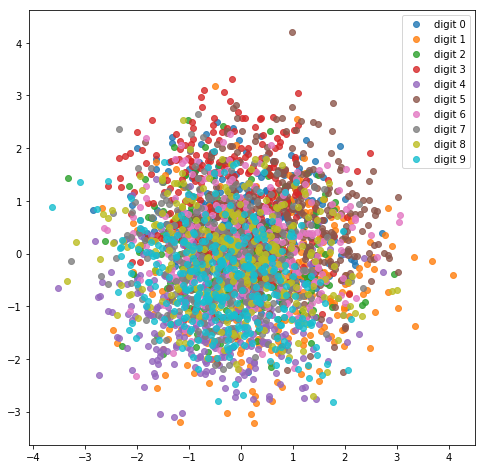

In [1474]:
index_list = []
for i in range(10):
    index_list.append(y_batch == i)

plt.figure(figsize=(8,8))
for i in range(10):
    plt.scatter(
        X2d[:, 0][index_list[i]], 
        X2d[:, 1][index_list[i]], 
        #cmap=y_batch[index_list[i]], 
        label=str('digit ' + str(i)), marker='o', alpha=0.8
    )
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')
plt.legend()
plt.show()

Color bar visualization looks better than legend.

Possible `colormap` values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

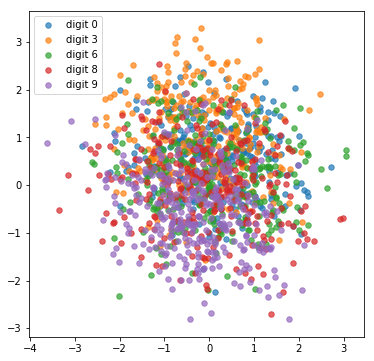

In [1475]:
digit_list = [0, 3, 6, 8, 9]

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)

plt.figure(figsize=(6,6))
for i in range(len(index_list)):
    plt.scatter(X2d[index_list[i], 0], X2d[index_list[i], 1], 
        s=30, cmap=y_batch[index_list[i]], marker='o', alpha=0.7,
        label=str('digit ' + str(digit_list[i])), 
    )
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')
plt.legend()
plt.show()

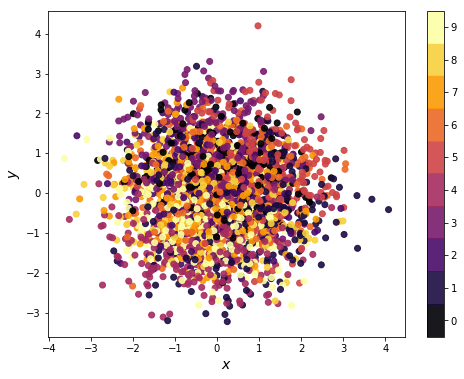

In [1476]:
fig = plt.figure(figsize=(8,6))

colors = y_batch
colormap = plt.get_cmap('inferno', 10)

p = plt.scatter(X2d[:, 0], X2d[:, 1],
        c=colors, cmap=colormap, marker='o', alpha=0.9
)

plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
plt.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5 * (9.0/10.0), 1.5*.... etc
tick_labels = [d for d in range(10)]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

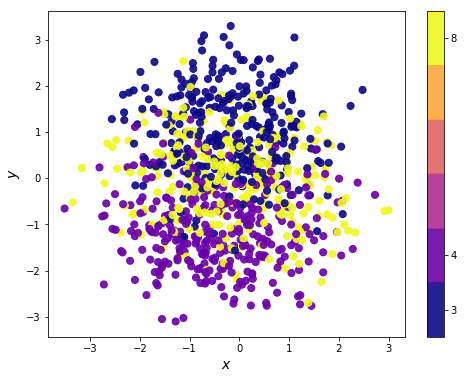

In [1483]:
digit_list = [3, 4, 8]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(8,6))

colors = y_batch[indeces]
colormap = plt.get_cmap('plasma', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=50, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

`KernelPCA` gives us different kernels to work with. Here are some common kernels:
* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a}^T - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

Options:
* `n_components` : int, default=None
* `kernel=` : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
* `gamma` : float, default=1/n_features
* `degree` : int, default=3 (for poly kernels)
* `coef0` : float, default=1 (independent term in poly and sigmoid kernels, ignored by other kernels)


In [1484]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.05, degree=2)
X2d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X2d.shape)

Compressed (3000, 24) into (3000, 2)


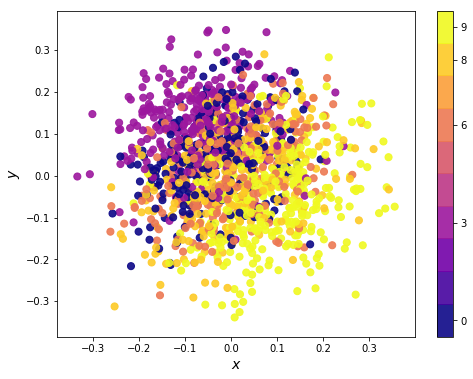

In [1485]:
digit_list = [0, 3, 6, 8, 9]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

plt.figure(figsize=(8,6))

colors = y_batch[indeces]
colormap = plt.get_cmap('plasma', n_bins)

p = plt.scatter(X2d[indeces, 0], X2d[indeces, 1], 
        s=50, c=colors, cmap=colormap, marker='o', alpha=0.9
)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14)
#plt.xlim((-1, 1))
#plt.ylim((-1, 1))
plt.axis('tight')

cbar = plt.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

### 3D

In [1461]:
from keras.models import load_model

#model_name = 'k_auto1'
model_name = 'k_auto_var3'

encoder_file = 'models/auto/mnist/' + model_name + '-enc'
decoder_file = 'models/auto/mnist/' + model_name + '-dec'

encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

n_codings = encoder.layers[-1].output_shape[1]
print(n_codings)

24


In [1464]:
n_points = 3000
X_batch, y_batch = random_batch(X_train, y_train, n_points)
X_enc = encoder.predict(X_batch)[0]

In [1465]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X3d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X3d.shape)

Compressed (3000, 24) into (3000, 3)


Possible `colormap` values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r

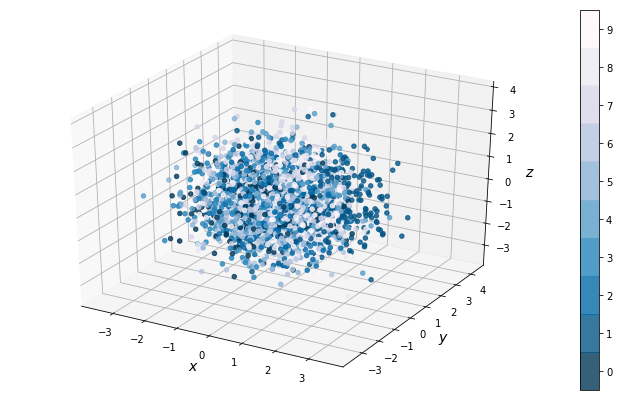

In [1466]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,7))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch# / 9.0
colormap = plt.get_cmap('PuBu_r', 10)

p = ax3d.scatter3D(
        X3d[:, 0], X3d[:, 1], X3d[:, 2],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)

ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5 * (9.0/10.0), 1.5*.... etc
tick_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

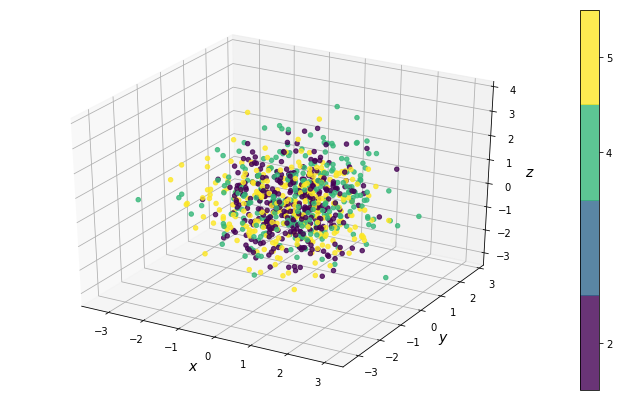

In [1467]:
from mpl_toolkits.mplot3d import Axes3D

digit_list = [2, 4, 5]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

fig = plt.figure(figsize=(12,7))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch[indeces]
colormap = plt.get_cmap('viridis', n_bins)

p = ax3d.scatter3D(X3d[:, 0][indeces], X3d[:, 1][indeces], X3d[:, 2][indeces],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)
ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

`KernelPCA` gives us different kernels to work with. Here are some common kernels:
* Linear: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \cdot \mathbf{b}$
* Polynomial: $K(\mathbf{a}, \mathbf{b}) = (\gamma\mathbf{a}^T \cdot \mathbf{b} + r)^d$
* Gaussian RBF: $K(\mathbf{a}, \mathbf{b}) = \exp(-\gamma \|\mathbf{a}^T - \mathbf{b}\|^2)$
* Sigmoid: $K(\mathbf{a}, \mathbf{b}) = \tanh(\gamma\mathbf{a}^T \cdot \mathbf{b} + r)$

Options:
* `n_components` : int, default=None
* `kernel=` : “linear” | “poly” | “rbf” | “sigmoid” | “cosine” | “precomputed”
* `gamma` : float, default=1/n_features
* `degree` : int, default=3 (for poly kernels)
* `coef0` : float, default=1 (independent term in poly and sigmoid kernels, ignored by other kernels)


In [1468]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components=3, kernel='cosine', gamma=0.15, degree=-1)
X3d = pca.fit_transform(X_enc)
print("Compressed", X_enc.shape, "into", X3d.shape)

Compressed (3000, 24) into (3000, 3)


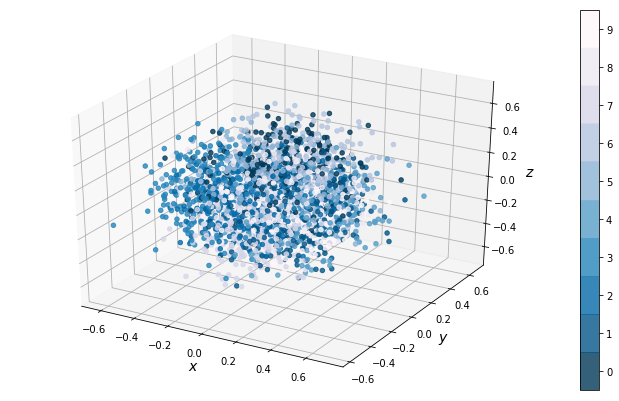

In [1469]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,7))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch# / 9.0
colormap = plt.get_cmap('PuBu_r', 10)

p = ax3d.scatter3D(X3d[:, 0], X3d[:, 1], X3d[:, 2],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)

ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
# The color bar values range from 0 to 9 (10 total values), and
# each data point should have a label located at the middle of each bin.
# The bins are: 0.5 * (9.0/10.0), 1.5*.... etc
tick_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tick_locations = []
for i in tick_labels:
    tick_locations.append(  (i + 0.5)*(9.0/10.0)  ) 
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

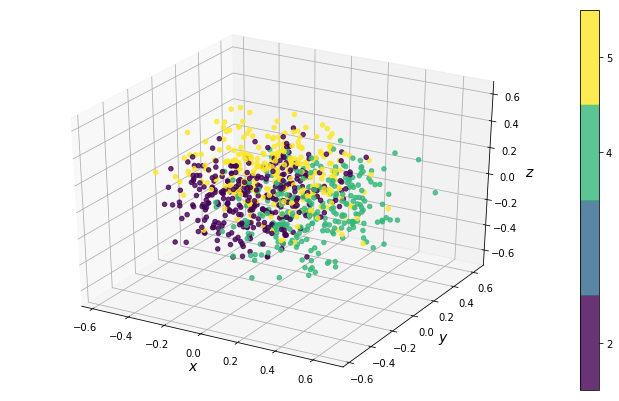

In [1470]:
from mpl_toolkits.mplot3d import Axes3D

digit_list = [2, 4, 5]

n_digits = len(digit_list)
digit_min = min(digit_list)
digit_max = max(digit_list)
digit_range = np.float(digit_max - digit_min)

n_bins = digit_range + 1
delta = digit_range/(digit_range+1.0)

index_list = []
for d in digit_list:
    index_list.append(y_batch == d)
indeces = (sum(index_list) == 1)

fig = plt.figure(figsize=(12,7))
ax3d = fig.add_subplot(111, projection='3d')

colors = y_batch[indeces]
colormap = plt.get_cmap('viridis', n_bins)

p = ax3d.scatter3D(X3d[:, 0][indeces], X3d[:, 1][indeces], X3d[:, 2][indeces],
        c=colors, cmap=colormap, marker='o', alpha=0.8
)
ax3d.set_xlabel("$x$", fontsize=14)
ax3d.set_ylabel("$y$", fontsize=14)
ax3d.set_zlabel("$z$", fontsize=14)
#ax.set_xlim([xmin, xmax])
#ax.set_ylim([ymin, ymax])
#ax.set_zlim([zmin, zmax])
ax3d.axis('tight')

cbar = fig.colorbar(p)
tick_labels = digit_list
tick_locations = []
for i in range(n_digits):
    tick_locations.append(  digit_min + delta/2.0 + (tick_labels[i] - digit_min) * delta  )
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(tick_labels)

plt.show()

## Conditional VAE `k_auto_cvae0`

In [55]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.layers.merge import concatenate

n_codings = 30# n_attributes + 30
model_name = 'k_auto_cvae0'

encoder_file = 'models/auto/celeb64-1/' + model_name + '-enc'
decoder_file = 'models/auto/celeb64-1/' + model_name + '-dec'
model_file = 'models/auto/celeb-1/' + model_name + '-model'

In [56]:
K.clear_session()
n_inputs = height * width * channels

def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    #return param_0 + param_1 * normal_01
    return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
inputs = Input(shape=(height, width, channels,), name='inputs')
condits = Input(shape=(n_attributes,), name='condits')

conv1 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(pool4)
#merged = concatenate([flatten, condits], axis=-1, name='merged')

dense = Dense(units=250, activation='relu')(flatten)#(merged)

param_0 = Dense(n_codings, name='param_0')(dense)
param_1 = Dense(n_codings, name='param_1')(dense)
codings0 = Lambda(sampling, output_shape=(n_codings,), name='codings1')([param_0, param_1])

codings = concatenate([codings0, condits], axis=-1, name='codings')

encoder = Model([inputs, condits], [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 8)    208         inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 8)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 8)    1608        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [59]:
print(encoder.layers[-1].output_shape)
print(encoder.layers[-2].output_shape)
print(encoder.layers[-8].output_shape)

(None, 33)
(None, 3)
(None, 4, 4, 32)


In [60]:
# Build the decoder part of the model
#
n_outputs = n_inputs
conv_layer_index = -8

latent_inputs = Input(shape=(n_codings + n_attributes,), name='latent_inputs')
#latent_condits = Input(shape=(n_attributes,), name='latent_condits')

#inputs_condits = concatenate([latent_inputs, latent_condits], axis=-1, name='inputs_condits')

dense3 = Dense(250, activation='relu')(latent_inputs)#(inputs_condits)
dense4 = Dense(500, activation='relu')(dense3)

h0 = encoder.layers[conv_layer_index].output_shape[1]
w0 = encoder.layers[conv_layer_index].output_shape[2]
feats = 64
dense5 = Dense(units=h0*w0*feats, activation='relu')(dense4)

reshape = Reshape(target_shape=(h0, w0, feats,))(dense5)

up1 = UpSampling2D(size=(2,2))(reshape)
conv5 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(up1)

up2 = UpSampling2D(size=(2,2))(conv5)
conv6 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(up2)

up3 = UpSampling2D(size=(2,2))(conv6)
conv7 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(up3)

up4 = UpSampling2D(size=(2,2))(conv7)
conv8 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(up4)

conv = Conv2D(filters=1, kernel_size=5, strides=1, padding='same')(conv8)
output = Activation('sigmoid', name='output')(conv)

decoder = Model([latent_inputs], output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 33)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               8500      
_________________________________________________________________
dense_3 (Dense)              (None, 500)               125500    
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              513024    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          51232     
__________

In [61]:
# Stack the two together
#
outputs = decoder(  encoder([inputs, condits])[0]  )
model = Model([inputs, condits], outputs, name='vae')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
condits (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 33), (None,  161174      inputs[0][0]                     
                                                                 condits[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 64, 64, 1)    740113      encoder[1][0]                    
Total para

### Loss and Optimizer

In [62]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 64, 64, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
dist_loss = K.square(param_0) + K.exp(param_1) - 1 - param_1
#dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.10)

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 64, 64, 1) (?, 64, 64, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
condits (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 33), (None,  161174      inputs[0][0]                     
                                                                 condits[0][0]                    
__________________________________________________________________________________________________
decoder (Model) 

### Train / Save / Restore

In [63]:
epochs = 30
batch_size = 150

history = model.fit(
    x=[X_train, X_cond], batch_size=batch_size, epochs=epochs, verbose=1
)


# compile and fit
#cvae_hist = cvae.fit(
#    [X_train, y_train], X_train, verbose = 0, batch_size=m, epochs=n_epoch,
#    validation_data = ([X_test, y_test], X_test),
#    callbacks = [EarlyStopping(patience = 5),
#    TQDMNotebookCallback(metric_format="{name}: {value:0.1f}",
#    leave_outer=False)]
#)

Epoch 1/30
101144/101144 [==============================] - 92s 905us/step - loss: 143.2887
Epoch 2/30
101144/101144 [==============================] - 86s 852us/step - loss: 106.6017
Epoch 3/30
101144/101144 [==============================] - 87s 865us/step - loss: 101.9887
Epoch 4/30
101144/101144 [==============================] - 87s 863us/step - loss: 99.8080
Epoch 5/30
101144/101144 [==============================] - 87s 864us/step - loss: 98.0675
Epoch 6/30
101144/101144 [==============================] - 87s 860us/step - loss: 96.8630
Epoch 7/30
101144/101144 [==============================] - 87s 860us/step - loss: 96.3394
Epoch 8/30
101144/101144 [==============================] - 87s 864us/step - loss: 95.7347
Epoch 9/30
101144/101144 [==============================] - 87s 863us/step - loss: 95.3413
Epoch 10/30
101144/101144 [==============================] - 88s 865us/step - loss: 94.8150
Epoch 11/30
101144/101144 [==============================] - 88s 866us/step - loss: 94

KeyboardInterrupt: 

In [64]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
#model.save(model_file + '.h5')

In [1360]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.compile(loss='binary_crossentropy', optimizer="adam")

### Reconstruction Output

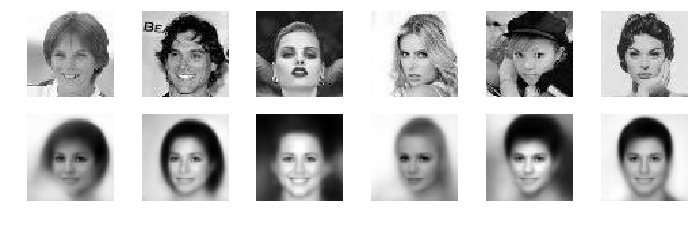

In [65]:
n_images = 6

images_in, cond_in = random_batch(X_train, X_cond, batch_size=n_images)
images_out = model.predict([images_in, cond_in])

fig = plt.figure(figsize=(12, 3.5))
for image_index in range(n_images):
    plt.subplot(2, n_images, image_index + 1)
    plot_image(images_in[image_index].reshape(64,64))
    
    plt.subplot(2, n_images, n_images + image_index + 1)
    plot_image(images_out[image_index].reshape(64,64))
plt.show()

### Generative

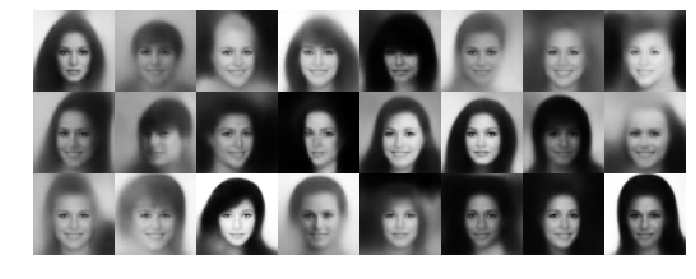

In [119]:
cols = 8
rows = 3
n_faces = rows * cols

#codings_in = noise = np.random.uniform(-2, 2, n_faces * n_codings).reshape((n_faces, n_codings))
codings_in = noise = np.random.normal(
    0, 1.2, n_faces * (n_codings+n_attributes)
).reshape((n_faces, n_codings+n_attributes))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols*1.5, rows*1.5))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

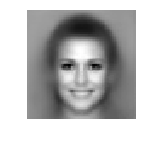

In [117]:
codings_in = np.array([[
    0.0, +0.0, 0.0, 0.0, +0.0, +0.0, 0.0, +0.0, 0.0, 0.0,
    +0.0, 0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0
]])

images_out = decoder.predict(codings_in)
image = combine_images(images_out)

fig = plt.figure(figsize=(2, 2))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

### Encoding Distributions

In [81]:
# encoder_output contains 3 variables: [ codings, param_0, param_1 ]
encoder_output = encoder.predict([X_train, X_cond], verbose=True)
print(encoder_output[0].shape)

101144/101144 [==============================] - 14s 134us/step
(101144, 33)


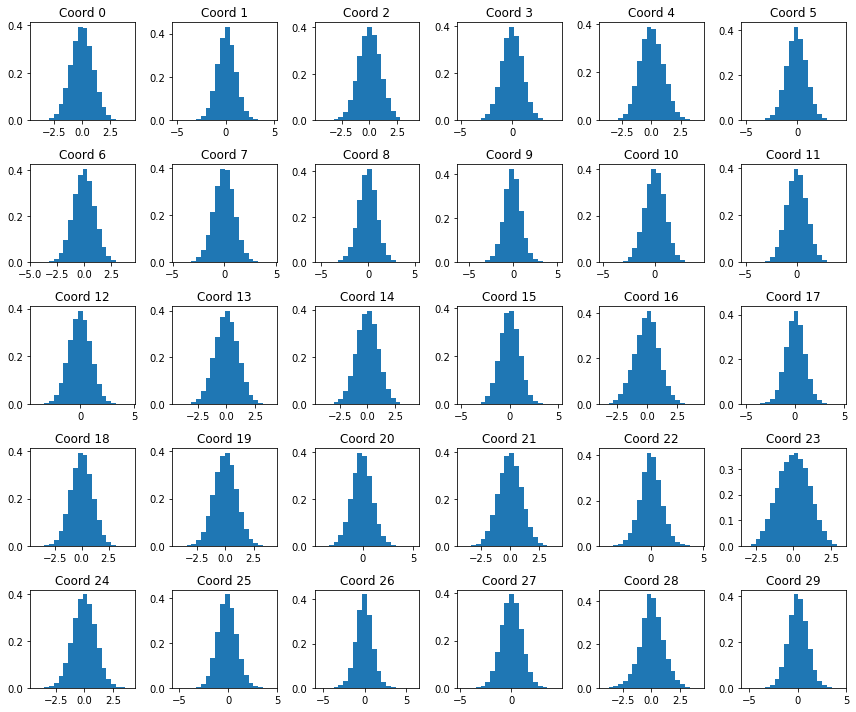

In [87]:
X_encoded = encoder_output[0]
showAll = True

coord_indeces = np.array([
    [ 0, 1, 2, 3, 4],
    [ 5, 6, 7, 8, 9]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

In [9]:
print()

# Celeb-a (128x128x1)

* <b>5_o_Clock_Shadow</b>
* Arched_Eyebrows 
* <b>Attractive</b>
* Bags_Under_Eyes 
* Bald 
* Bangs 
* Big_Lips 
* Big_Nose 
* Black_Hair 
* Blond_Hair 
* <b>Blurry</b>
* Brown_Hair 
* Bushy_Eyebrows 
* Chubby 
* Double_Chin 
* <b>Eyeglasses</b>
* Goatee 
* Gray_Hair 
* Heavy_Makeup 
* High_Cheekbones 
* <b>Male</b>
* Mouth_Slightly_Open 
* Mustache 
* Narrow_Eyes 
* <b>No_Beard</b>
* Oval_Face 
* Pale_Skin 
* Pointy_Nose 
* Receding_Hairline 
* Rosy_Cheeks 
* Sideburns 
* <b>Smiling</b>
* Straight_Hair 
* Wavy_Hair 
* Wearing_Earrings 
* Wearing_Hat 
* Wearing_Lipstick 
* Wearing_Necklace 
* Wearing_Necktie 
* <b>Young</b>

## Data

In [61]:
# This needs to be edited by hand. Features we are interested in are:
# #### Basic Attributes ####
# attr.Male
# attr.Attractive
# attr.Smiling
# attr.Young
# attr.Mouth_Slightly_Open
#
# #### Facial Features ####
# 
# attr.Big_Lips
# attr.Big_Nose
# attr.High_Cheekbones
#
# attr.Heavy_Makeup OR attr.Wearing_Lipstick
# attr.Straight_Hair
# attr.Wavy_Hair
# attr.Black_Hair OR attr.Brown_Hair
# attr.Blond_Hair
# attr.No_Beard
#
def image_filter(i, attr):
    if attr.Blurry[i] == 1:# we only want high-quality non-blurry photos
        return False
    if attr.Male[i] == 1:
        return False
    if attr.Attractive[i] == -1:
        return False
    if attr.Eyeglasses[i] == 1:
        return False
    if attr.Young[i] == -1:
        return False
    return True    
    
#############################################################
#
height = 128
width = 128
channels = 1
n_attributes = 3

subfolder = str(height) + "x" + str(width) + "-" + str(channels)
ROOT_PATH = os.path.join("D:/datasets/celeb-aligned/" + subfolder)
#print(ROOT_PATH)

image_paths = []
attr = pd.read_csv("D:/datasets/celeb-aligned/list_attr_celeba.csv")

for i in range(attr.image_id.shape[0]):
    print("\rFiltering images... {:}% (found {:})"
          .format(round(100*i / attr.image_id.shape[0], 1), len(image_paths)), end="")
    sys.stdout.flush()
    filename = attr.image_id[i]
    if image_filter(i, attr):
        image_path = os.path.join(ROOT_PATH, filename)
        image_paths.append(image_path)
        
#np.random.shuffle(image_paths)

Filtering images... 100.0% (found 73909)

In [62]:
# Load the data to RAM (if it fits!), then normalize it
#
dataset_size = 73900 #should be at least 1000

def conditioning_vector(i, attr):
    attr_vector = np.zeros(3) #we keep track of 9 features (see above)
    #attr_vector[0] = attr.Male[i]
    if attr.Smiling[i] == 1:
        attr_vector[0] = 1
    #attr_vector[2] = attr.Young[i]
    if attr.Mouth_Slightly_Open[i] == 1:
        attr_vector[1] = 1
    if attr.Heavy_Makeup[i] == 1 or attr.Wearing_Lipstick[i] == 1:
        attr_vector[2] = 1
    #if attr.Black_Hair[i] == 1 or attr.Brown_Hair[i] == 1:
    #    attr_vector[5] = 1
    #if attr.Blond_Hair[i] == 1:
    #    attr_vector[6] = 1
    #if attr.No_Beard[i] == -1: #complement of having no beard
    #    attr_vector[7] = 1
    return attr_vector;

m = min(len(image_paths), dataset_size)

X_train = np.zeros([m, height, width, channels])
X_cond = np.zeros([m, n_attributes])

for i in range(m):
    if i % (m // 1000) == 0:
        print("\rLoading data to RAM... {:}% ".format(round(100*i / m, 1)), end="")
        sys.stdout.flush()
    image_path = image_paths[i]
    image = mpimg.imread(image_path)#[:, :, :]
    X_cond[i] = conditioning_vector(i, attr)
    if channels == 1:
        X_train[i] = image.astype("float32").reshape([height, width, channels]) / 255.0
    else:
        X_train[i] = image.astype("float32") / 255.0 #.reshape([height, width, channels])
print("done:", X_train.shape, X_cond.shape)

Loading data to RAM... 100.0% done: (73900, 128, 128, 1) (73900, 3)


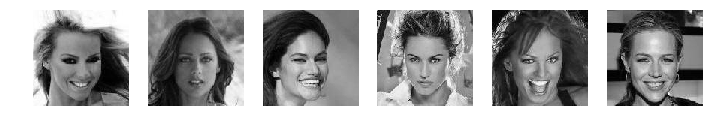

In [63]:
n_examples = 6

X_batch = random_batch_1d(X_train, n_examples)

plt.figure(figsize=(12,4))
for i in range(n_examples):
    image = X_batch[i]
    #print(image.shape)
    plt.subplot(1, n_examples, i + 1)
    plt.axis("off")
    if channels == 1:
        plt.imshow(image.reshape([height,width]), cmap="gray", interpolation="nearest")
    else:
        plt.imshow(image)
plt.show()

In [64]:
#X_train = X_train * 2 - 1
#X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], channels))

print(X_train.shape, np.min(X_train), np.max(X_train))

(73900, 128, 128, 1) 0.0 1.0


## VAE 'k_auto_var0'

In [66]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.engine.input_layer import Input
from keras.layers.core import Activation, Dense, Flatten, Reshape, Lambda
from keras.layers import Dropout, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D

n_codings = 30
model_name = 'k_auto_var0'

encoder_file = 'models/auto/celeb128-1/' + model_name + '-enc'
decoder_file = 'models/auto/celeb128-1/' + model_name + '-dec'
model_file = 'models/auto/celeb-1/' + model_name + '-model'

Using TensorFlow backend.


In [68]:
K.clear_session()
n_inputs = height * width * channels

def sampling(args):
    param_0, param_1 = args
    batch_size = K.shape(param_0)[0]
    dim = K.int_shape(param_0)[1]
    
    #unif_01 = K.random_uniform(shape=(batch_size, dim))
    normal_01 = K.random_normal(shape=(batch_size, dim))
    
    #return param_0 + param_1 * normal_01
    return param_0 + K.exp(0.5 * param_1) * normal_01


# Build the encoder part of the model
#
inputs = Input(shape=(height, width, channels,), name='inputs')

conv1 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(filters=42, kernel_size=5, strides=1, padding='same', activation='relu')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(filters=52, kernel_size=5, strides=1, padding='same', activation='relu')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

flatten = Flatten()(pool4)

dense = Dense(units=500, activation='relu')(flatten)
#dense = Dense(units=120, activation='relu')(dense1)

param_0 = Dense(n_codings, name='param_0')(dense)
param_1 = Dense(n_codings, name='param_1')(dense)
codings = Lambda(sampling, output_shape=(n_codings,), name='codings')([param_0, param_1])

encoder = Model(inputs, [codings, param_0, param_1], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 416         inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   12832       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [72]:
encoder.layers[-1].output_shape
print(encoder.layers[-6].output_shape)

(None, 8, 8, 52)


In [74]:
# Build the decoder part of the model
#
n_outputs = n_inputs
conv_layer_index = -6

latent_inputs = Input(shape=(n_codings,), name='latent_inputs')
dense3 = Dense(500, activation='relu')(latent_inputs)
#dense4 = Dense(450, activation='relu')(dense3)

h0 = encoder.layers[conv_layer_index].output_shape[1]
w0 = encoder.layers[conv_layer_index].output_shape[2]
feats = 128
dense5 = Dense(units=h0*w0*feats, activation='relu')(dense3)

reshape = Reshape(target_shape=(h0, w0, feats,))(dense5)

up1 = UpSampling2D(size=(2,2))(reshape)
conv5 = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(up1)

up2 = UpSampling2D(size=(2,2))(conv5)
conv6 = Conv2D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu')(up2)

up3 = UpSampling2D(size=(2,2))(conv6)
conv7 = Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu')(up3)

up4 = UpSampling2D(size=(2,2))(conv7)
conv8 = Conv2D(filters=8, kernel_size=5, strides=1, padding='same', activation='relu')(up4)

conv = Conv2D(filters=1, kernel_size=5, strides=1, padding='same')(conv8)
output = Activation('sigmoid', name='output')(conv)

decoder = Model(latent_inputs, output, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_inputs (InputLayer)   (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               15500     
_________________________________________________________________
dense_5 (Dense)              (None, 8192)              4104192   
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        204864    
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 32, 32, 64)        0         
__________

In [75]:
# Stack the two together
#
outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 128, 128, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 30), (None, 30),  1796102   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 1)       4392013   
Total params: 6,188,115
Trainable params: 6,188,115
Non-trainable params: 0
_________________________________________________________________


### Loss and Optimizer

In [76]:
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.losses import mse, binary_crossentropy

# Calculate the reconstruction loss. We use MSE. Note that since inputs/outputs are of
# shape (?, 64, 64, 1), we cannot simply call mse(inputs, outputs) as this would result
# in the MSE being calculated only along the last axis=-1, instead of over the entire image
#
# Fix: we use the backend to write the MSE explicitly
#
print("inputs/outputs shapes:", inputs.shape, outputs.shape)
reconstruction_loss = K.sum(K.square(outputs - inputs), axis=[1, 2, 3])
#reconstruction_loss = binary_crossentropy(inputs, outputs)
#reconstruction_loss *= np.sqrt(n_inputs)
#reconstruction_loss *= n_inputs
print("rec_loss:", reconstruction_loss.shape)


# Calculate the distribution loss (KL-div for Gaussian has a closed form)
#
epsilon = 1e-10
dist_loss = K.square(param_0) + K.exp(param_1) - 1 - param_1
#dist_loss = K.square(param_0) + K.square(param_1) - 1 - K.log( epsilon + K.square(param_1) )
dist_loss = 0.5 * K.sum(dist_loss, axis=-1)
print("dist_loss:", dist_loss.shape)

loss = K.mean(reconstruction_loss + dist_loss)
#loss = K.mean(reconstruction_loss)
#loss = K.mean(dist_loss)
print("loss:", loss.shape)

#optimizer = SGD()
#optimizer = SGD(lr=0.003, momentum=0.7, nesterov=True)
optimizer = Adam()
#optimizer = Adam(lr=0.001)
#optimizer = RMSprop()
#optimizer = RMSprop(lr=0.001)
#optimizer = Adagrad()
#optimizer = Adagrad(lr=0.001)
#optimizer = Adadelta()
#optimizer = Adadelta(lr=0.15)

encoder.compile(loss='binary_crossentropy', optimizer="adam")
decoder.compile(loss='binary_crossentropy', optimizer="adam")
model.add_loss(loss)
model.compile(optimizer=optimizer)
model.summary()

inputs/outputs shapes: (?, 128, 128, 1) (?, 128, 128, 1)
rec_loss: (?,)
dist_loss: (?,)
loss: ()
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 128, 128, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 30), (None, 30),  1796102   
_________________________________________________________________
decoder (Model)              (None, 128, 128, 1)       4392013   
Total params: 6,188,115
Trainable params: 6,188,115
Non-trainable params: 0
_________________________________________________________________


### Train / Save / Restore

In [77]:
epochs = 50
batch_size = 100

history = model.fit(
    X_train, batch_size=batch_size, epochs=epochs, verbose=1
)





Epoch 1/50
73900/73900 [==============================] - 324s 4ms/step - loss: 410.7223
Epoch 2/50
73900/73900 [==============================] - 317s 4ms/step - loss: 278.1354
Epoch 3/50
73900/73900 [==============================] - 312s 4ms/step - loss: 265.5491
Epoch 4/50
73900/73900 [==============================] - 312s 4ms/step - loss: 258.7122
Epoch 5/50
73900/73900 [==============================] - 312s 4ms/step - loss: 253.8128
Epoch 6/50
73900/73900 [==============================] - 312s 4ms/step - loss: 250.8447
Epoch 7/50
73900/73900 [==============================] - 311s 4ms/step - loss: 247.8669
Epoch 8/50
73900/73900 [==============================] - 311s 4ms/step - loss: 246.1613
Epoch 9/50
73900/73900 [==============================] - 312s 4ms/step - loss: 244.1098
Epoch 10/50
73900/73900 [==============================] - 312s 4ms/step - loss: 242.7098
Epoch 11/50
73900/73900 [==============================] - 312s 4ms/step - loss: 241.7403
Epoch 12/50
73900/7

In [78]:
# Save the encoder, decoder, and stacked models
#
encoder.save(encoder_file + '.h5')
decoder.save(decoder_file + '.h5')
#model.save(model_file + '.h5')

In [1360]:
from keras.models import load_model

# Restore a saved model if it exists
#
encoder = load_model(encoder_file + '.h5')
decoder = load_model(decoder_file + '.h5')

outputs = decoder(  encoder(inputs)[0]  )
model = Model(inputs, outputs, name='vae')
model.compile(loss='binary_crossentropy', optimizer="adam")

### Reconstruction Output

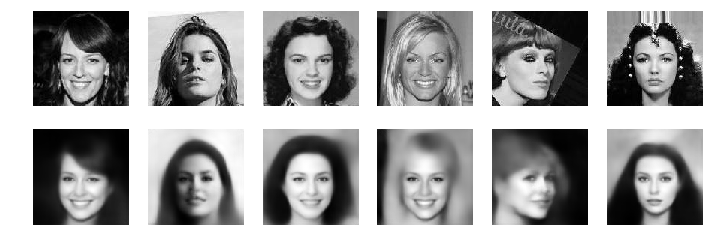

In [81]:
n_images = 6

images_in = random_batch_1d(X_train, batch_size=n_images)
images_out = model.predict(images_in)

fig = plt.figure(figsize=(12, 4))
for image_index in range(n_images):
    plt.subplot(2, n_images, image_index + 1)
    plot_image(images_in[image_index].reshape(height,width))
    
    plt.subplot(2, n_images, n_images + image_index + 1)
    plot_image(images_out[image_index].reshape(height,width))
plt.show()

### Encoding Distributions

In [82]:
# encoder_output contains 3 variables: [ codings, param_0, param_1 ]
encoder_output = encoder.predict(X_train, verbose=True)
print(encoder_output[0].shape)

73900/73900 [==============================] - 38s 509us/step
(73900, 30)


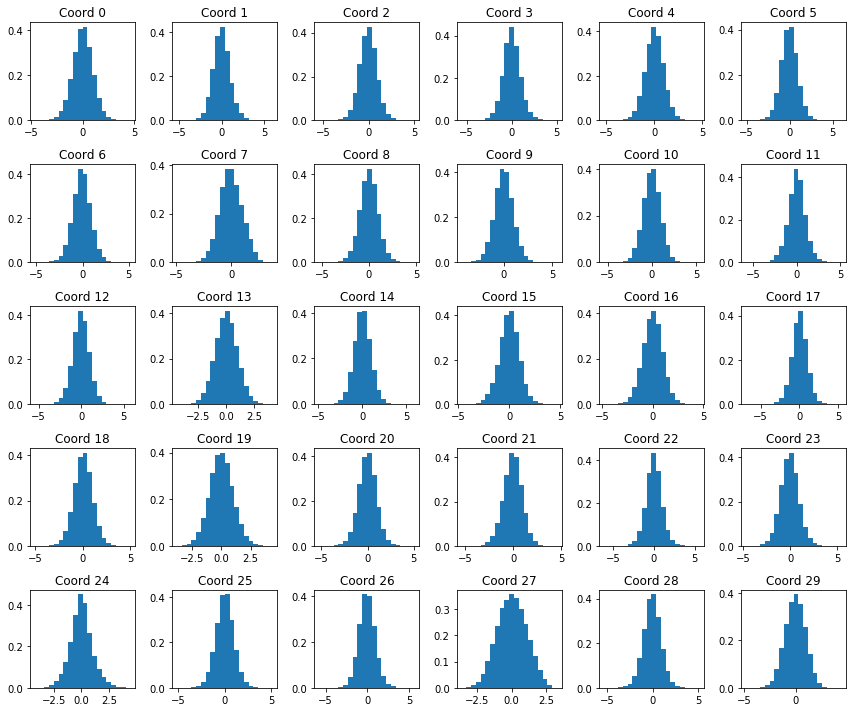

In [84]:
X_encoded = encoder_output[0]
showAll = True

coord_indeces = np.array([
    [ 0, 3, 5],
    [ 11, 14, 19]
])

if showAll:
    n_cols = 6
    n_rows = X_encoded.shape[1] // n_cols
else:
    n_cols = coord_indeces.shape[1]
    n_rows = coord_indeces.shape[0]

plt.figure(figsize=(12, int(12.0/n_cols * n_rows)))
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        if showAll:
            plt.title("Coord " + str(i))
            plt.hist(X_encoded[:, i], bins=20, density=True)
        else:
            plt.title("Coord " + str(coord_indeces[row, col]))
            plt.hist(X_encoded[:, coord_indeces[row, col]], bins=20, density=True)
plt.tight_layout()
plt.show()

### Generative

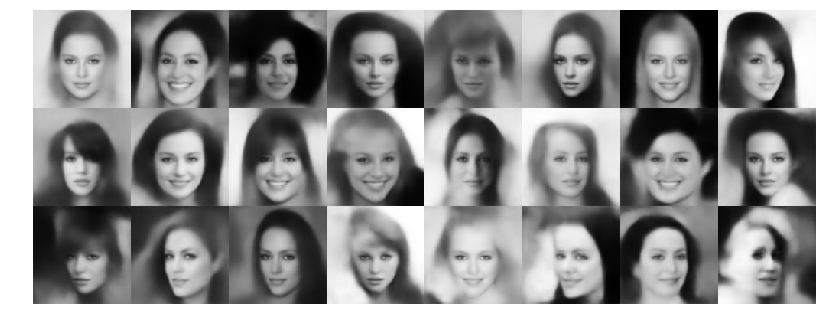

In [90]:
cols = 8
rows = 3
n_faces = rows * cols

#codings_in = noise = np.random.uniform(-2, 2, n_faces * n_codings).reshape((n_faces, n_codings))
codings_in = noise = np.random.normal(0, 1.2, n_faces * n_codings).reshape((n_faces, n_codings))
images_out = decoder.predict(codings_in)

image = combine_images(images_out, rows, cols)

fig = plt.figure(figsize=(cols*1.8, rows*1.8))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

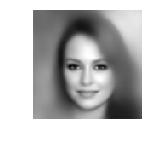

In [96]:
codings_in = np.array([[
    +3.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +2.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0,
    +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0, +0.0
]])

images_out = decoder.predict(codings_in)
image = combine_images(images_out)

fig = plt.figure(figsize=(2, 2))
plt.imshow(image, cmap="gray", interpolation='nearest')
plt.axis("off")
plt.show()

### Interpolating Faces

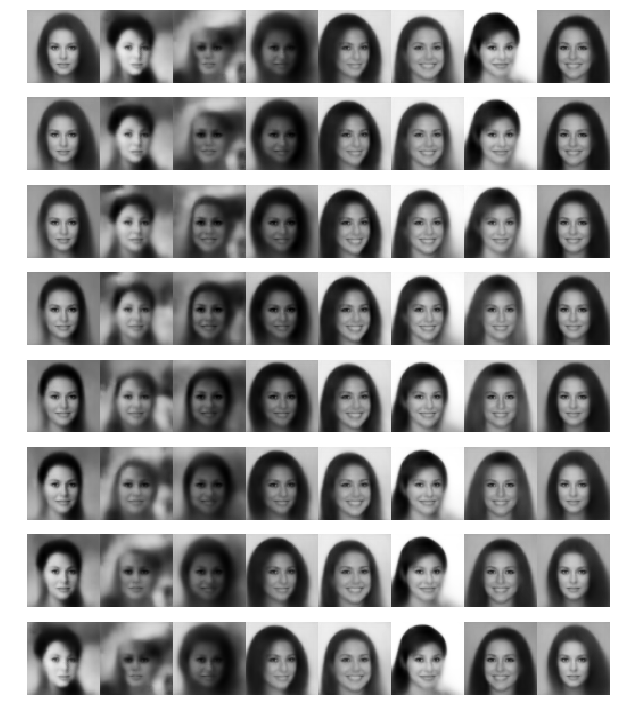

In [201]:
n_digits = 8
n_iterations = 7

#codings_in = noise = np.random.uniform(-2, 2, n_digits * n_codings).reshape((n_digits, n_codings))
codings_in = noise = np.random.normal(0, 1.0, n_digits * n_codings).reshape((n_digits, n_codings))
codings_target = target_codings = np.roll(codings_in, -1, axis=0)
difference = codings_target - codings_in

images = []

for iteration in range(n_iterations + 1):
    codings_interpolate = codings_in + difference * iteration / n_iterations
    images_out = decoder.predict(codings_interpolate)
    image = combine_images(images_out, rows=1, cols=n_digits)
    images.append(image)


fig = plt.figure(figsize=(1.8*n_digits, 1.8*n_iterations))
for i in range(n_iterations + 1):
    plt.subplot(n_iterations+1, 1, i+1)
    plt.imshow(images[i], cmap="gray", interpolation='nearest')
    plt.axis("off")

plt.show()

In [65]:
print()